# Scalable Tensorflow Dataset Introduction

In [1]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np

## Datasets, Pandas, and Numpy

In [2]:
df = pd.DataFrame(range(10))
df

,0
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [3]:
df.values

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [4]:
type(df.values)

numpy.ndarray

In [5]:
tf.data.Dataset.from_tensor_slices(df)

<TensorSliceDataset shapes: (1,), types: tf.int64>

In [6]:
ds_from_tensor_slices = tf.data.Dataset.from_tensor_slices(df)
list(ds_from_tensor_slices.as_numpy_iterator())

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [7]:
ds_from_tensors = tf.data.Dataset.from_tensors(df)
list(ds_from_tensors.as_numpy_iterator())

[array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])]

In [8]:
print("0th element from ds from tensor slices:", next(ds_from_tensor_slices.as_numpy_iterator()))
print()
print("0th element from ds from tensors:", next(ds_from_tensors.as_numpy_iterator()))

0th element from ds from tensor slices: [0]

0th element from ds from tensors: [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]


In [9]:
range_ds = tf.data.Dataset.from_tensor_slices(list(range(10)))
print(range_ds)
print(list(range_ds.as_numpy_iterator()))

<TensorSliceDataset shapes: (), types: tf.int32>
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [10]:
def print_ds(ds: tf.data.Dataset) -> None:
    print(list(ds.as_numpy_iterator()))

In [11]:
interleaved_ds = range_ds.interleave(lambda i: tf.data.Dataset.from_tensor_slices(range(i)))
print(interleaved_ds)
print_ds(interleaved_ds)

<InterleaveDataset shapes: (), types: tf.int32>
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 4, 4, 4, 4, 3, 5, 5, 5, 4, 6, 6, 5, 7, 6, 7, 8]


In [12]:
print_ds(interleaved_ds.shuffle(buffer_size=10))
print_ds(interleaved_ds.shuffle(buffer_size=100))

[0, 0, 0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 2, 2, 0, 0, 1, 2, 3, 1, 2, 0, 4, 4, 2, 4, 3, 3, 2, 1, 5, 4, 5, 5, 7, 6, 7, 5, 8, 3, 6, 4, 6, 3, 3]
[6, 1, 2, 0, 1, 0, 8, 0, 2, 1, 4, 2, 3, 2, 0, 6, 4, 2, 0, 3, 1, 5, 1, 0, 5, 3, 1, 1, 0, 4, 3, 3, 6, 7, 2, 0, 2, 5, 7, 0, 1, 4, 5, 4, 3]


In [13]:
print_ds(interleaved_ds.batch(10))

[array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32), array([1, 1, 1, 1, 1, 0, 2, 2, 2, 2], dtype=int32), array([2, 2, 1, 3, 3, 3, 3, 3, 2, 4], dtype=int32), array([4, 4, 4, 3, 5, 5, 5, 4, 6, 6], dtype=int32), array([5, 7, 6, 7, 8], dtype=int32)]


In [14]:
print("first batch - then shuffle:")
print_ds(interleaved_ds.batch(10).shuffle(10))
print()
print("first shuffle - then batch:")
print_ds(interleaved_ds.shuffle(10).batch(10))

first batch - then shuffle:
[array([2, 2, 1, 3, 3, 3, 3, 3, 2, 4], dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int32), array([1, 1, 1, 1, 1, 0, 2, 2, 2, 2], dtype=int32), array([4, 4, 4, 3, 5, 5, 5, 4, 6, 6], dtype=int32), array([5, 7, 6, 7, 8], dtype=int32)]

first shuffle - then batch:
[array([0, 1, 1, 0, 0, 1, 1, 0, 1, 0], dtype=int32), array([2, 2, 0, 1, 2, 1, 3, 3, 2, 0], dtype=int32), array([0, 0, 1, 4, 4, 2, 5, 3, 3, 5], dtype=int32), array([5, 6, 2, 2, 7, 3, 6, 7, 3, 8], dtype=int32), array([5, 4, 4, 4, 6], dtype=int32)]


# Datasets and Generators: What if the data doesn't fit into memory?

In [15]:
for i in range(3):
    print(i)

0
1
2


In [16]:
try:
    tf.data.Dataset.from_tensor_slices(range(3))
except TypeError as e:
    print(e)

'list' object cannot be interpreted as an integer


In [17]:
try:
    tf.data.Dataset.from_tensors(range(3))
except TypeError as e:
    print(e)

'list' object cannot be interpreted as an integer


* cannot use tf.data.Dataset.from_tensor_slices
* cannot use tf.data.Dataset.from_tensors

In [18]:
def int_generator():
    yield from range(3)
    
ds_from_int_generator = tf.data.Dataset.from_generator(
    generator=int_generator,
    output_types=tf.int32
)
print(ds_from_int_generator)
print_ds(ds_from_int_generator)

<FlatMapDataset shapes: <unknown>, types: tf.int32>
[0, 1, 2]


In [19]:
def tuple_generator():
    yield from zip(range(3), reversed(range(3)))
    
ds_from_tuple_generator = tf.data.Dataset.from_generator(
    generator=tuple_generator,
    output_types=(tf.int32, tf.int32)
)
print(ds_from_tuple_generator)
print_ds(ds_from_tuple_generator)

<FlatMapDataset shapes: (<unknown>, <unknown>), types: (tf.int32, tf.int32)>
[(0, 2), (1, 1), (2, 0)]


In [20]:
tfds.benchmark(ds_from_tuple_generator)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 94.30 ex/sec (total: 3 ex, 0.03 sec)
Examples/sec (First only) 100.52 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 91.46 ex/sec (total: 2 ex, 0.02 sec)


,duration,num_examples,avg
first+lasts,0.031815,3,94.295253
first,0.009948,1,100.523173
lasts,0.021867,2,91.461987


## Attention: Python code can be really slow

In [21]:
benchmark_size = 2 * 10**4

# dataframe in-memory
large_df = pd.DataFrame(range(benchmark_size), dtype=np.int32)
large_ds_from_tensor_slices = tf.data.Dataset.from_tensor_slices(large_df)

# generator in-memory
def large_generator():
    yield from range(benchmark_size)
large_ds_from_generator = tf.data.Dataset.from_generator(
    generator=large_generator,
    output_types=tf.int32
)

print("from tensor slices:")
tfds.benchmark(large_ds_from_tensor_slices)

print()
print()

print("from generator:")
tfds.benchmark(large_ds_from_generator)

from tensor slices:


  0%|          | 1/20000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 20812.96 ex/sec (total: 20000 ex, 0.96 sec)
Examples/sec (First only) 462.65 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 20858.84 ex/sec (total: 19999 ex, 0.96 sec)


from generator:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3234.15 ex/sec (total: 20000 ex, 6.18 sec)
Examples/sec (First only) 103.18 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3239.06 ex/sec (total: 19999 ex, 6.17 sec)


,duration,num_examples,avg
first+lasts,6.184014,20000,3234.145122
first,0.009691,1,103.184384
lasts,6.174323,19999,3239.059565


## The generator is ~7x slower.

In [22]:
print("batched from tensor slices:")
tfds.benchmark(large_ds_from_tensor_slices.batch(128))

print()
print()

print("batched from generator:")
tfds.benchmark(large_ds_from_generator.batch(128))

batched from tensor slices:


  1%|          | 1/157 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 3995.42 ex/sec (total: 157 ex, 0.04 sec)
Examples/sec (First only) 414.87 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 4229.41 ex/sec (total: 156 ex, 0.04 sec)


batched from generator:


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 40.25 ex/sec (total: 157 ex, 3.90 sec)
Examples/sec (First only) 28.72 ex/sec (total: 1 ex, 0.03 sec)
Examples/sec (First excluded) 40.35 ex/sec (total: 156 ex, 3.87 sec)


,duration,num_examples,avg
first+lasts,3.900783,157,40.248334
first,0.034816,1,28.722453
lasts,3.865967,156,40.352133


## even batched Generators are not that fast...
### You can use generators, but they are not optimal... However, nothing is impossible with them!

more complex generators:

In [23]:
# imo the prettiest way to implement 'method classes'

class MyGenerator:
    def __init__(self, benchmark_size: int) -> None:
        self.benchmark_size = benchmark_size
    
    def __call__(self, msg: str = "Hello"):
        print(f"I was run with '{msg}'!")
        yield from range(self.benchmark_size)

next(MyGenerator(1)(msg="world"))

I was run with 'world'!


0

In [24]:
ds_from_generator_class = tf.data.Dataset.from_generator(
    generator=MyGenerator(10**4),
    output_types=tf.int32
)

tfds.benchmark(ds_from_generator_class)

I was run with 'Hello'!


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3658.08 ex/sec (total: 10000 ex, 2.73 sec)
Examples/sec (First only) 96.27 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3671.67 ex/sec (total: 9999 ex, 2.72 sec)


,duration,num_examples,avg
first+lasts,2.733673,10000,3658.082184
first,0.010387,1,96.270880
lasts,2.723286,9999,3671.667908


## Better Option: read Dataset asynchronously from Files
### Dump Dataframes into Dataset Files

In [25]:
DUMP_PATH_PREFIX = 'test'

In [26]:
rm -r $DUMP_PATH_PREFIX

In [27]:
mkdir $DUMP_PATH_PREFIX

In [28]:
ls $DUMP_PATH_PREFIX

In [29]:
large_df_for_dumping = pd.DataFrame(range(50_000), dtype=np.int32)
large_ds_for_dumping = tf.data.Dataset.from_tensor_slices(large_df_for_dumping)

In [30]:
len(large_ds_for_dumping)

50000

In [31]:
print(large_ds_for_dumping)

<TensorSliceDataset shapes: (1,), types: tf.int32>


In [32]:
dump_paths = []

for i in range(4):
    dump_path = os.path.join(DUMP_PATH_PREFIX, f"{i}.dataset")
    tf.data.experimental.save(
        dataset=large_ds_for_dumping,
        path=dump_path,
        compression='GZIP'
    )
    print(f"stored to '{dump_path}'")
    dump_paths.append(dump_path)

stored to 'test/0.dataset'
stored to 'test/1.dataset'
stored to 'test/2.dataset'
stored to 'test/3.dataset'


In [33]:
print(os.popen(f"du -h --summarize {os.path.join(DUMP_PATH_PREFIX, '*')}").read())

2.5K	test/0.dataset
2.5K	test/1.dataset
2.5K	test/2.dataset
2.5K	test/3.dataset



### Load Datasets

In [34]:
dumped_files_ds = tf.data.Dataset.from_tensor_slices(dump_paths)
print(dumped_files_ds)
print_ds(dumped_files_ds)

<TensorSliceDataset shapes: (), types: tf.string>
[b'test/0.dataset', b'test/1.dataset', b'test/2.dataset', b'test/3.dataset']


In [35]:
element_spec = (tf.TensorSpec(shape=(1,), dtype=tf.int32),)
element_spec

(TensorSpec(shape=(1,), dtype=tf.int32, name=None),)

In [36]:
loaded_files_ds = dumped_files_ds.interleave(lambda path:
    tf.data.experimental.load(
        path=path,
        element_spec=element_spec,
        compression='GZIP'
    )
)
print(loaded_files_ds)

<InterleaveDataset shapes: ((1,),), types: (tf.int32,)>


In [37]:
try:
    len(loaded_files_ds)
except TypeError as e:
    print(e)

dataset length is unknown.


In [38]:
# looks like round robin
print_ds(loaded_files_ds.take(12))

[(array([0], dtype=int32),), (array([0], dtype=int32),), (array([0], dtype=int32),), (array([0], dtype=int32),), (array([1], dtype=int32),), (array([1], dtype=int32),), (array([1], dtype=int32),), (array([1], dtype=int32),), (array([2], dtype=int32),), (array([2], dtype=int32),), (array([2], dtype=int32),), (array([2], dtype=int32),)]


In [39]:
tfds.benchmark(loaded_files_ds)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13469.24 ex/sec (total: 200000 ex, 14.85 sec)
Examples/sec (First only) 84.13 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13479.96 ex/sec (total: 199999 ex, 14.84 sec)


,duration,num_examples,avg
first+lasts,14.848647,200000,13469.240870
first,0.011886,1,84.133315
lasts,14.836761,199999,13479.963832


## Reading from Files is 3-4x faster than reading from a Generator

In [40]:
from typing import List

def load_ds_from_files(file_paths: List[str]) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices(file_paths)
    ds = ds.interleave(lambda path:
        tf.data.experimental.load(
            path=path,
            element_spec=element_spec,
            compression='GZIP'
        ))
    return ds

In [41]:
tfds.benchmark(
    load_ds_from_files(dump_paths)\
    .shuffle(buffer_size=10**5)\
    .batch(128, drop_remainder=True)
)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 1946.12 ex/sec (total: 1562 ex, 0.80 sec)
Examples/sec (First only) 3.60 ex/sec (total: 1 ex, 0.28 sec)
Examples/sec (First excluded) 2975.85 ex/sec (total: 1561 ex, 0.52 sec)


,duration,num_examples,avg
first+lasts,0.802625,1562,1946.115348
first,0.278068,1,3.596242
lasts,0.524557,1561,2975.847182


## >10x Speed Improvement by using Batching 

In [42]:
tfds.benchmark(
    load_ds_from_files(dump_paths)\
    .shuffle(buffer_size=10**4)\
    .batch(128, drop_remainder=True)\
    .prefetch(tf.data.experimental.AUTOTUNE)
)

1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 2466.22 ex/sec (total: 1562 ex, 0.63 sec)
Examples/sec (First only) 21.10 ex/sec (total: 1 ex, 0.05 sec)
Examples/sec (First excluded) 2664.02 ex/sec (total: 1561 ex, 0.59 sec)


,duration,num_examples,avg
first+lasts,0.633357,1562,2466.222645
first,0.047402,1,21.096328
lasts,0.585956,1561,2664.024196


## Another 10-20% (at least) by using Prefetching

# Combined Benchmark

In [2]:
def get_dataset_from_tensor(size):
    df = pd.DataFrame(range(size), dtype=np.int32)
    ds = tf.data.Dataset.from_tensor_slices(df)
    return ds

def get_dataset_from_generator(size):
    def gen():
        yield from range(size)
    
    ds = tf.data.Dataset.from_generator(
        generator=gen,
        output_types=tf.int32
    )
    return ds

def get_dataset_from_files(size, shard_count = 10):
    assert size % shard_count == 0
    one_ds = get_dataset_from_tensor(size//shard_count)
    
    dump_paths = []
    for i in range(shard_count):
        dump_path = f"{i}.dataset"
        tf.data.experimental.save(
            dataset=one_ds,
            path=dump_path,
            compression='GZIP'
        )
        
        dump_paths.append(dump_path)
    
    ds = load_ds_from_files(dump_paths)
    return ds

def benchmark_ds(ds, batch_size = None, prefetch = None):
    if batch_size is not None:
        ds = ds.batch(batch_size)
    else:
        batch_size = 1
    
    if prefetch is not None:
        ds = ds.prefetch(prefetch)
        
    return tfds.benchmark(ds, batch_size=batch_size).stats.avg['first+lasts']

def run_benchmark_with_size(size, batch_size = None, prefetch = None):
    results = dict()
    
    results['dataset_from_tensor'] = benchmark_ds(get_dataset_from_tensor(size), batch_size, prefetch)
    results['dataset_from_generator'] = benchmark_ds(get_dataset_from_generator(size), batch_size, prefetch)
    results['dataset_from_files'] = benchmark_ds(get_dataset_from_files(size), batch_size, prefetch)
    
    return results

def run_benchmark(sizes = (10**3, 10**4, 10**5, 10**6), batch_sizes = (None, 10, 25, 100, 250), prefetches = (None, tf.data.experimental.AUTOTUNE)):
    results = dict()
    
    for size in sizes:
        print(f"size = {size}")
        for batch_size in batch_sizes:
            print(f"batch_size = {batch_size}")
            for prefetch in prefetches:
                print(f"prefetch = {prefetch}")
                results[(size, batch_size, prefetch)] = run_benchmark_with_size(size, batch_size, prefetch)
    
    return results

def visualize_benchmark_results(res):
    df = pd.DataFrame(res)\
    .T\
    .reset_index()\
    .rename(columns={
        'level_0': 'size', 
        'level_1': 'batch_size', 
        'level_2': 'prefetch'
    })
    return df

In [44]:
results = []
for _ in range(5):
    res = run_benchmark()
    results.append(res)

size = 1000
batch_size = None
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 14324.52 ex/sec (total: 1000 ex, 0.07 sec)
Examples/sec (First only) 468.91 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 14761.13 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3436.34 ex/sec (total: 1000 ex, 0.29 sec)
Examples/sec (First only) 96.84 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3559.20 ex/sec (total: 999 ex, 0.28 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 9119.99 ex/sec (total: 1000 ex, 0.11 sec)
Examples/sec (First only) 94.40 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 10085.17 ex/sec (total: 999 ex, 0.10 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 13940.88 ex/sec (total: 1000 ex, 0.07 sec)
Examples/sec (First only) 458.20 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 14363.98 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4200.85 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 92.27 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4396.83 ex/sec (total: 999 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8659.41 ex/sec (total: 1000 ex, 0.12 sec)
Examples/sec (First only) 91.53 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9554.72 ex/sec (total: 999 ex, 0.10 sec)
batch_size = 10
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 35098.84 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4314.48 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 37824.96 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4301.18 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 844.09 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4486.80 ex/sec (total: 990 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 18552.99 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 513.51 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 28757.31 ex/sec (total: 990 ex, 0.03 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 36040.97 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4098.71 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 39120.52 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4431.73 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 764.32 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4657.47 ex/sec (total: 990 ex, 0.21 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20174.10 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 530.63 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 32223.47 ex/sec (total: 990 ex, 0.03 sec)
batch_size = 25
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37744.20 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 11458.62 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 40103.04 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4542.33 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 1560.17 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4776.43 ex/sec (total: 975 ex, 0.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20756.29 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1337.60 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 33064.39 ex/sec (total: 975 ex, 0.03 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 34351.55 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 10460.40 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 36488.42 ex/sec (total: 975 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4217.87 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 1649.23 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4393.32 ex/sec (total: 975 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20528.32 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1211.88 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 34717.08 ex/sec (total: 975 ex, 0.03 sec)
batch_size = 100
prefetch = None


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39528.86 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 43810.44 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 39104.23 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4692.56 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 3697.20 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4837.26 ex/sec (total: 900 ex, 0.19 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22452.65 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 5054.56 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 36357.69 ex/sec (total: 900 ex, 0.02 sec)
prefetch = -1


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40385.57 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 41135.79 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 40303.90 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4581.24 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 3173.72 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4818.69 ex/sec (total: 900 ex, 0.19 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 19766.43 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 4743.17 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 30500.33 ex/sec (total: 900 ex, 0.03 sec)
batch_size = 250
prefetch = None


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40799.06 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 104820.18 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 33897.79 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4734.34 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 4411.89 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4852.55 ex/sec (total: 750 ex, 0.15 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22233.93 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12091.73 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 30862.90 ex/sec (total: 750 ex, 0.02 sec)
prefetch = -1


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37942.55 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 72509.25 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 32739.94 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4362.45 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 4111.08 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4453.21 ex/sec (total: 750 ex, 0.17 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20453.98 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 12127.91 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 26523.66 ex/sec (total: 750 ex, 0.03 sec)
size = 10000
batch_size = None
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19756.21 ex/sec (total: 10000 ex, 0.51 sec)
Examples/sec (First only) 398.69 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19852.61 ex/sec (total: 9999 ex, 0.50 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3378.73 ex/sec (total: 10000 ex, 2.96 sec)
Examples/sec (First only) 98.22 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3390.05 ex/sec (total: 9999 ex, 2.95 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13094.24 ex/sec (total: 10000 ex, 0.76 sec)
Examples/sec (First only) 90.94 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13284.21 ex/sec (total: 9999 ex, 0.75 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 18650.28 ex/sec (total: 10000 ex, 0.54 sec)
Examples/sec (First only) 340.61 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 18751.08 ex/sec (total: 9999 ex, 0.53 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4500.51 ex/sec (total: 10000 ex, 2.22 sec)
Examples/sec (First only) 98.13 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4520.79 ex/sec (total: 9999 ex, 2.21 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13354.64 ex/sec (total: 10000 ex, 0.75 sec)
Examples/sec (First only) 90.89 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13552.43 ex/sec (total: 9999 ex, 0.74 sec)
batch_size = 10
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 124777.52 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4347.23 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 128336.35 ex/sec (total: 9990 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4785.55 ex/sec (total: 10000 ex, 2.09 sec)
Examples/sec (First only) 848.92 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4807.87 ex/sec (total: 9990 ex, 2.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 66740.84 ex/sec (total: 10000 ex, 0.15 sec)
Examples/sec (First only) 510.20 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 76708.56 ex/sec (total: 9990 ex, 0.13 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 127262.01 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4129.92 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 131176.92 ex/sec (total: 9990 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4872.67 ex/sec (total: 10000 ex, 2.05 sec)
Examples/sec (First only) 807.26 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4897.36 ex/sec (total: 9990 ex, 2.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 82911.96 ex/sec (total: 10000 ex, 0.12 sec)
Examples/sec (First only) 489.03 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 99739.08 ex/sec (total: 9990 ex, 0.10 sec)
batch_size = 25
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 189557.54 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 11165.28 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 197464.75 ex/sec (total: 9975 ex, 0.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4951.44 ex/sec (total: 10000 ex, 2.02 sec)
Examples/sec (First only) 1801.17 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4973.24 ex/sec (total: 9975 ex, 2.01 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 100977.33 ex/sec (total: 10000 ex, 0.10 sec)
Examples/sec (First only) 1243.95 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 126370.03 ex/sec (total: 9975 ex, 0.08 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 199398.37 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 9773.05 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 209590.50 ex/sec (total: 9975 ex, 0.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4828.15 ex/sec (total: 10000 ex, 2.07 sec)
Examples/sec (First only) 1580.75 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4853.14 ex/sec (total: 9975 ex, 2.06 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 123954.49 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 1250.11 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 164396.37 ex/sec (total: 9975 ex, 0.06 sec)
batch_size = 100
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 269083.11 ex/sec (total: 10000 ex, 0.04 sec)
Examples/sec (First only) 42513.86 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 284392.33 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4897.37 ex/sec (total: 10000 ex, 2.04 sec)
Examples/sec (First only) 3225.10 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4923.15 ex/sec (total: 9900 ex, 2.01 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 135799.27 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 5043.24 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 183982.16 ex/sec (total: 9900 ex, 0.05 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 331590.93 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 40487.73 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 357558.77 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4912.91 ex/sec (total: 10000 ex, 2.04 sec)
Examples/sec (First only) 3145.01 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4940.96 ex/sec (total: 9900 ex, 2.00 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 143880.06 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 4256.78 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 215168.68 ex/sec (total: 9900 ex, 0.05 sec)
batch_size = 250
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 297153.09 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 77542.82 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 320421.58 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4944.56 ex/sec (total: 10000 ex, 2.02 sec)
Examples/sec (First only) 4612.23 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 4953.71 ex/sec (total: 9750 ex, 1.97 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 128137.40 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 10304.76 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 181292.16 ex/sec (total: 9750 ex, 0.05 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 332526.91 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 92801.88 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 356114.39 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5103.60 ex/sec (total: 10000 ex, 1.96 sec)
Examples/sec (First only) 4340.86 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5126.70 ex/sec (total: 9750 ex, 1.90 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 155459.85 ex/sec (total: 10000 ex, 0.06 sec)
Examples/sec (First only) 11736.42 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 226617.34 ex/sec (total: 9750 ex, 0.04 sec)
size = 100000
batch_size = None
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 20863.36 ex/sec (total: 100000 ex, 4.79 sec)
Examples/sec (First only) 486.33 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 20872.11 ex/sec (total: 99999 ex, 4.79 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3301.98 ex/sec (total: 100000 ex, 30.28 sec)
Examples/sec (First only) 100.48 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3303.03 ex/sec (total: 99999 ex, 30.27 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13848.83 ex/sec (total: 100000 ex, 7.22 sec)
Examples/sec (First only) 88.12 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13870.49 ex/sec (total: 99999 ex, 7.21 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19470.39 ex/sec (total: 100000 ex, 5.14 sec)
Examples/sec (First only) 451.57 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19478.59 ex/sec (total: 99999 ex, 5.13 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4577.47 ex/sec (total: 100000 ex, 21.85 sec)
Examples/sec (First only) 98.39 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4579.56 ex/sec (total: 99999 ex, 21.84 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13799.20 ex/sec (total: 100000 ex, 7.25 sec)
Examples/sec (First only) 86.55 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13821.09 ex/sec (total: 99999 ex, 7.24 sec)
batch_size = 10
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 174656.39 ex/sec (total: 100000 ex, 0.57 sec)
Examples/sec (First only) 4459.82 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 175325.54 ex/sec (total: 99990 ex, 0.57 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4771.38 ex/sec (total: 100000 ex, 20.96 sec)
Examples/sec (First only) 811.11 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4773.72 ex/sec (total: 99990 ex, 20.95 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 87729.86 ex/sec (total: 100000 ex, 1.14 sec)
Examples/sec (First only) 424.26 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 89573.30 ex/sec (total: 99990 ex, 1.12 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 181042.62 ex/sec (total: 100000 ex, 0.55 sec)
Examples/sec (First only) 3966.90 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 181854.47 ex/sec (total: 99990 ex, 0.55 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4922.94 ex/sec (total: 100000 ex, 20.31 sec)
Examples/sec (First only) 834.52 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4925.36 ex/sec (total: 99990 ex, 20.30 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 118062.51 ex/sec (total: 100000 ex, 0.85 sec)
Examples/sec (First only) 400.66 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 121634.93 ex/sec (total: 99990 ex, 0.82 sec)
batch_size = 25
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 366448.18 ex/sec (total: 100000 ex, 0.27 sec)
Examples/sec (First only) 5771.46 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 372265.65 ex/sec (total: 99975 ex, 0.27 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4994.53 ex/sec (total: 100000 ex, 20.02 sec)
Examples/sec (First only) 1621.42 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4997.13 ex/sec (total: 99975 ex, 20.01 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 158599.43 ex/sec (total: 100000 ex, 0.63 sec)
Examples/sec (First only) 1031.73 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 164896.81 ex/sec (total: 99975 ex, 0.61 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 420190.16 ex/sec (total: 100000 ex, 0.24 sec)
Examples/sec (First only) 9928.02 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 424577.53 ex/sec (total: 99975 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4946.13 ex/sec (total: 100000 ex, 20.22 sec)
Examples/sec (First only) 1566.39 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4948.80 ex/sec (total: 99975 ex, 20.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 240930.09 ex/sec (total: 100000 ex, 0.42 sec)
Examples/sec (First only) 1022.14 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 255952.67 ex/sec (total: 99975 ex, 0.39 sec)
batch_size = 100
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 727981.99 ex/sec (total: 100000 ex, 0.14 sec)
Examples/sec (First only) 31689.00 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 744353.82 ex/sec (total: 99900 ex, 0.13 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5058.02 ex/sec (total: 100000 ex, 19.77 sec)
Examples/sec (First only) 3092.12 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5061.24 ex/sec (total: 99900 ex, 19.74 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 283283.43 ex/sec (total: 100000 ex, 0.35 sec)
Examples/sec (First only) 4343.84 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 302743.59 ex/sec (total: 99900 ex, 0.33 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1217983.21 ex/sec (total: 100000 ex, 0.08 sec)
Examples/sec (First only) 40945.46 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1254069.37 ex/sec (total: 99900 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5083.11 ex/sec (total: 100000 ex, 19.67 sec)
Examples/sec (First only) 3028.55 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5086.57 ex/sec (total: 99900 ex, 19.64 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 362276.04 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 3997.06 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 397985.44 ex/sec (total: 99900 ex, 0.25 sec)
batch_size = 250
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1035687.63 ex/sec (total: 100000 ex, 0.10 sec)
Examples/sec (First only) 105450.22 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1059103.59 ex/sec (total: 99750 ex, 0.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5039.24 ex/sec (total: 100000 ex, 19.84 sec)
Examples/sec (First only) 4251.09 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5041.59 ex/sec (total: 99750 ex, 19.79 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 273573.88 ex/sec (total: 100000 ex, 0.37 sec)
Examples/sec (First only) 9630.74 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 293750.91 ex/sec (total: 99750 ex, 0.34 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1282232.65 ex/sec (total: 100000 ex, 0.08 sec)
Examples/sec (First only) 71958.93 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1338660.90 ex/sec (total: 99750 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5097.49 ex/sec (total: 100000 ex, 19.62 sec)
Examples/sec (First only) 4693.78 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5098.59 ex/sec (total: 99750 ex, 19.56 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 363262.73 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 10022.51 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 398459.68 ex/sec (total: 99750 ex, 0.25 sec)
size = 1000000
batch_size = None
prefetch = None


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21141.43 ex/sec (total: 1000000 ex, 47.30 sec)
Examples/sec (First only) 448.03 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21142.41 ex/sec (total: 999999 ex, 47.30 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3258.36 ex/sec (total: 1000000 ex, 306.90 sec)
Examples/sec (First only) 97.89 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3258.47 ex/sec (total: 999999 ex, 306.89 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13910.70 ex/sec (total: 1000000 ex, 71.89 sec)
Examples/sec (First only) 89.79 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13912.84 ex/sec (total: 999999 ex, 71.88 sec)
prefetch = -1


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19614.57 ex/sec (total: 1000000 ex, 50.98 sec)
Examples/sec (First only) 325.21 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19615.74 ex/sec (total: 999999 ex, 50.98 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4572.47 ex/sec (total: 1000000 ex, 218.70 sec)
Examples/sec (First only) 94.88 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4572.69 ex/sec (total: 999999 ex, 218.69 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13922.03 ex/sec (total: 1000000 ex, 71.83 sec)
Examples/sec (First only) 80.22 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13924.43 ex/sec (total: 999999 ex, 71.82 sec)
batch_size = 10
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 178052.13 ex/sec (total: 1000000 ex, 5.62 sec)
Examples/sec (First only) 4111.16 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 178127.50 ex/sec (total: 999990 ex, 5.61 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4796.26 ex/sec (total: 1000000 ex, 208.50 sec)
Examples/sec (First only) 846.30 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4796.48 ex/sec (total: 999990 ex, 208.48 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 91781.99 ex/sec (total: 1000000 ex, 10.90 sec)
Examples/sec (First only) 382.92 ex/sec (total: 10 ex, 0.03 sec)
Examples/sec (First excluded) 92001.59 ex/sec (total: 999990 ex, 10.87 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 186241.99 ex/sec (total: 1000000 ex, 5.37 sec)
Examples/sec (First only) 3812.78 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 186331.15 ex/sec (total: 999990 ex, 5.37 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4966.46 ex/sec (total: 1000000 ex, 201.35 sec)
Examples/sec (First only) 833.52 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4966.71 ex/sec (total: 999990 ex, 201.34 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 123688.31 ex/sec (total: 1000000 ex, 8.08 sec)
Examples/sec (First only) 409.53 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 124061.77 ex/sec (total: 999990 ex, 8.06 sec)
batch_size = 25
prefetch = None


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 388360.25 ex/sec (total: 1000000 ex, 2.57 sec)
Examples/sec (First only) 4347.07 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 389219.85 ex/sec (total: 999975 ex, 2.57 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4941.31 ex/sec (total: 1000000 ex, 202.38 sec)
Examples/sec (First only) 1740.01 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4941.54 ex/sec (total: 999975 ex, 202.36 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 166959.58 ex/sec (total: 1000000 ex, 5.99 sec)
Examples/sec (First only) 1073.25 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 167607.24 ex/sec (total: 999975 ex, 5.97 sec)
prefetch = -1


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 457508.54 ex/sec (total: 1000000 ex, 2.19 sec)
Examples/sec (First only) 9595.58 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 458043.08 ex/sec (total: 999975 ex, 2.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5009.66 ex/sec (total: 1000000 ex, 199.61 sec)
Examples/sec (First only) 1558.85 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5009.93 ex/sec (total: 999975 ex, 199.60 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 291915.52 ex/sec (total: 1000000 ex, 3.43 sec)
Examples/sec (First only) 1002.81 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 294048.14 ex/sec (total: 999975 ex, 3.40 sec)
batch_size = 100
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 976754.45 ex/sec (total: 1000000 ex, 1.02 sec)
Examples/sec (First only) 18897.98 ex/sec (total: 100 ex, 0.01 sec)
Examples/sec (First excluded) 981730.91 ex/sec (total: 999900 ex, 1.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5043.35 ex/sec (total: 1000000 ex, 198.28 sec)
Examples/sec (First only) 3268.36 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5043.62 ex/sec (total: 999900 ex, 198.25 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 308756.21 ex/sec (total: 1000000 ex, 3.24 sec)
Examples/sec (First only) 3941.36 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 311162.91 ex/sec (total: 999900 ex, 3.21 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1805178.08 ex/sec (total: 1000000 ex, 0.55 sec)
Examples/sec (First only) 37237.49 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1813790.36 ex/sec (total: 999900 ex, 0.55 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5052.02 ex/sec (total: 1000000 ex, 197.94 sec)
Examples/sec (First only) 3649.62 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5052.22 ex/sec (total: 999900 ex, 197.91 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 412620.34 ex/sec (total: 1000000 ex, 2.42 sec)
Examples/sec (First only) 4087.49 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 416786.41 ex/sec (total: 999900 ex, 2.40 sec)
batch_size = 250
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1395381.30 ex/sec (total: 1000000 ex, 0.72 sec)
Examples/sec (First only) 53365.02 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1404211.74 ex/sec (total: 999750 ex, 0.71 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5067.31 ex/sec (total: 1000000 ex, 197.34 sec)
Examples/sec (First only) 4416.04 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5067.49 ex/sec (total: 999750 ex, 197.29 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 374452.25 ex/sec (total: 1000000 ex, 2.67 sec)
Examples/sec (First only) 10399.13 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 377759.22 ex/sec (total: 999750 ex, 2.65 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 2133932.81 ex/sec (total: 1000000 ex, 0.47 sec)
Examples/sec (First only) 91999.20 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 2145842.59 ex/sec (total: 999750 ex, 0.47 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5080.76 ex/sec (total: 1000000 ex, 196.82 sec)
Examples/sec (First only) 4744.80 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5080.85 ex/sec (total: 999750 ex, 196.77 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 424813.98 ex/sec (total: 1000000 ex, 2.35 sec)
Examples/sec (First only) 9586.95 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 429465.36 ex/sec (total: 999750 ex, 2.33 sec)
size = 1000
batch_size = None
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 13899.44 ex/sec (total: 1000 ex, 0.07 sec)
Examples/sec (First only) 487.69 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 14292.90 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3210.31 ex/sec (total: 1000 ex, 0.31 sec)
Examples/sec (First only) 101.34 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3312.02 ex/sec (total: 999 ex, 0.30 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8620.36 ex/sec (total: 1000 ex, 0.12 sec)
Examples/sec (First only) 93.48 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9486.53 ex/sec (total: 999 ex, 0.11 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 13569.72 ex/sec (total: 1000 ex, 0.07 sec)
Examples/sec (First only) 455.61 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 13972.30 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3943.76 ex/sec (total: 1000 ex, 0.25 sec)
Examples/sec (First only) 98.22 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4104.62 ex/sec (total: 999 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 9007.18 ex/sec (total: 1000 ex, 0.11 sec)
Examples/sec (First only) 92.93 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9963.89 ex/sec (total: 999 ex, 0.10 sec)
batch_size = 10
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 33635.00 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4447.39 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 36023.02 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4033.46 ex/sec (total: 1000 ex, 0.25 sec)
Examples/sec (First only) 796.94 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4206.00 ex/sec (total: 990 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 19397.90 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 506.80 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 31112.16 ex/sec (total: 990 ex, 0.03 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 30099.07 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4118.74 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 32147.35 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3952.63 ex/sec (total: 1000 ex, 0.25 sec)
Examples/sec (First only) 809.55 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4113.97 ex/sec (total: 990 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20128.13 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 487.87 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 33922.32 ex/sec (total: 990 ex, 0.03 sec)
batch_size = 25
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37679.43 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 11311.19 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 40074.84 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4479.61 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 1607.01 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4694.80 ex/sec (total: 975 ex, 0.21 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 19934.13 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1260.50 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 32144.51 ex/sec (total: 975 ex, 0.03 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37680.25 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 10414.79 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 40391.62 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4859.09 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 1544.45 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5142.05 ex/sec (total: 975 ex, 0.19 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21951.09 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1245.02 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 38271.64 ex/sec (total: 975 ex, 0.03 sec)
batch_size = 100
prefetch = None


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39159.31 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 42551.34 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 38815.51 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4291.47 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 3163.72 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4468.45 ex/sec (total: 900 ex, 0.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22409.70 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 4980.29 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 36668.24 ex/sec (total: 900 ex, 0.02 sec)
prefetch = -1


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40099.40 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 40725.83 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 40030.99 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4562.29 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 3411.42 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4739.96 ex/sec (total: 900 ex, 0.19 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22749.89 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 5107.69 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 36918.65 ex/sec (total: 900 ex, 0.02 sec)
batch_size = 250
prefetch = None


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 34947.98 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 75472.24 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 29642.54 ex/sec (total: 750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4605.42 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 4392.96 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4680.88 ex/sec (total: 750 ex, 0.16 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 23245.95 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12848.05 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 31833.55 ex/sec (total: 750 ex, 0.02 sec)
prefetch = -1


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40381.00 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 97587.48 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 33780.26 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4561.32 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 4487.12 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4586.61 ex/sec (total: 750 ex, 0.16 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 23053.74 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12231.01 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 32698.18 ex/sec (total: 750 ex, 0.02 sec)
size = 10000
batch_size = None
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 18694.93 ex/sec (total: 10000 ex, 0.53 sec)
Examples/sec (First only) 512.16 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 18761.54 ex/sec (total: 9999 ex, 0.53 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3406.21 ex/sec (total: 10000 ex, 2.94 sec)
Examples/sec (First only) 101.01 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3417.40 ex/sec (total: 9999 ex, 2.93 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13089.82 ex/sec (total: 10000 ex, 0.76 sec)
Examples/sec (First only) 94.72 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13271.93 ex/sec (total: 9999 ex, 0.75 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 18117.61 ex/sec (total: 10000 ex, 0.55 sec)
Examples/sec (First only) 456.00 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 18188.06 ex/sec (total: 9999 ex, 0.55 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4471.19 ex/sec (total: 10000 ex, 2.24 sec)
Examples/sec (First only) 96.87 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4491.48 ex/sec (total: 9999 ex, 2.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13290.93 ex/sec (total: 10000 ex, 0.75 sec)
Examples/sec (First only) 92.81 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13482.68 ex/sec (total: 9999 ex, 0.74 sec)
batch_size = 10
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 127711.06 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4524.82 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 131288.93 ex/sec (total: 9990 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4846.14 ex/sec (total: 10000 ex, 2.06 sec)
Examples/sec (First only) 828.59 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4869.77 ex/sec (total: 9990 ex, 2.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 67758.26 ex/sec (total: 10000 ex, 0.15 sec)
Examples/sec (First only) 496.49 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 78388.50 ex/sec (total: 9990 ex, 0.13 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 132109.41 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4092.69 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 136379.55 ex/sec (total: 9990 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4779.82 ex/sec (total: 10000 ex, 2.09 sec)
Examples/sec (First only) 791.69 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4804.05 ex/sec (total: 9990 ex, 2.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 79204.59 ex/sec (total: 10000 ex, 0.13 sec)
Examples/sec (First only) 462.69 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 95467.84 ex/sec (total: 9990 ex, 0.10 sec)
batch_size = 25
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 202608.47 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 11353.53 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 211539.48 ex/sec (total: 9975 ex, 0.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4916.35 ex/sec (total: 10000 ex, 2.03 sec)
Examples/sec (First only) 1703.49 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4939.70 ex/sec (total: 9975 ex, 2.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 101298.60 ex/sec (total: 10000 ex, 0.10 sec)
Examples/sec (First only) 1260.42 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 126452.53 ex/sec (total: 9975 ex, 0.08 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 216548.83 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 5168.91 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 241277.98 ex/sec (total: 9975 ex, 0.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5090.32 ex/sec (total: 10000 ex, 1.96 sec)
Examples/sec (First only) 1553.13 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5119.54 ex/sec (total: 9975 ex, 1.95 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 129945.74 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 1178.32 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 178960.78 ex/sec (total: 9975 ex, 0.06 sec)
batch_size = 100
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 292860.83 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 42093.92 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 311612.07 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5097.76 ex/sec (total: 10000 ex, 1.96 sec)
Examples/sec (First only) 3328.28 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5125.29 ex/sec (total: 9900 ex, 1.93 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 133231.62 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 5320.41 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 175963.32 ex/sec (total: 9900 ex, 0.06 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 315811.20 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 40643.17 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 338994.08 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4881.37 ex/sec (total: 10000 ex, 2.05 sec)
Examples/sec (First only) 3417.74 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4902.58 ex/sec (total: 9900 ex, 2.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 153485.15 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 5073.49 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 217857.37 ex/sec (total: 9900 ex, 0.05 sec)
batch_size = 250
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 324212.86 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 109117.13 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 341472.42 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5074.09 ex/sec (total: 10000 ex, 1.97 sec)
Examples/sec (First only) 4676.50 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5085.18 ex/sec (total: 9750 ex, 1.92 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 146082.64 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 12747.38 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 199621.11 ex/sec (total: 9750 ex, 0.05 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 319869.67 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 100752.58 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 338760.37 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4914.02 ex/sec (total: 10000 ex, 2.03 sec)
Examples/sec (First only) 3908.60 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4946.65 ex/sec (total: 9750 ex, 1.97 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 147563.66 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 12454.65 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 204425.93 ex/sec (total: 9750 ex, 0.05 sec)
size = 100000
batch_size = None
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21067.76 ex/sec (total: 100000 ex, 4.75 sec)
Examples/sec (First only) 509.76 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21076.26 ex/sec (total: 99999 ex, 4.74 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3372.98 ex/sec (total: 100000 ex, 29.65 sec)
Examples/sec (First only) 100.38 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3374.08 ex/sec (total: 99999 ex, 29.64 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13854.14 ex/sec (total: 100000 ex, 7.22 sec)
Examples/sec (First only) 90.15 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13875.32 ex/sec (total: 99999 ex, 7.21 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19537.39 ex/sec (total: 100000 ex, 5.12 sec)
Examples/sec (First only) 435.48 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19545.96 ex/sec (total: 99999 ex, 5.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4579.61 ex/sec (total: 100000 ex, 21.84 sec)
Examples/sec (First only) 97.81 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4581.71 ex/sec (total: 99999 ex, 21.83 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13836.91 ex/sec (total: 100000 ex, 7.23 sec)
Examples/sec (First only) 87.90 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13858.58 ex/sec (total: 99999 ex, 7.22 sec)
batch_size = 10
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 170215.99 ex/sec (total: 100000 ex, 0.59 sec)
Examples/sec (First only) 4519.82 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 170842.36 ex/sec (total: 99990 ex, 0.59 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4821.53 ex/sec (total: 100000 ex, 20.74 sec)
Examples/sec (First only) 826.53 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4823.86 ex/sec (total: 99990 ex, 20.73 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 88789.47 ex/sec (total: 100000 ex, 1.13 sec)
Examples/sec (First only) 405.50 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 90768.05 ex/sec (total: 99990 ex, 1.10 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 172533.37 ex/sec (total: 100000 ex, 0.58 sec)
Examples/sec (First only) 4021.93 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 173259.37 ex/sec (total: 99990 ex, 0.58 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4954.24 ex/sec (total: 100000 ex, 20.18 sec)
Examples/sec (First only) 789.61 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4956.85 ex/sec (total: 99990 ex, 20.17 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 117366.48 ex/sec (total: 100000 ex, 0.85 sec)
Examples/sec (First only) 430.27 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 120645.63 ex/sec (total: 99990 ex, 0.83 sec)
batch_size = 25
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 350577.77 ex/sec (total: 100000 ex, 0.29 sec)
Examples/sec (First only) 11311.61 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 353226.99 ex/sec (total: 99975 ex, 0.28 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4927.90 ex/sec (total: 100000 ex, 20.29 sec)
Examples/sec (First only) 1712.30 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4930.22 ex/sec (total: 99975 ex, 20.28 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 157969.03 ex/sec (total: 100000 ex, 0.63 sec)
Examples/sec (First only) 1045.69 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 164128.14 ex/sec (total: 99975 ex, 0.61 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 410515.15 ex/sec (total: 100000 ex, 0.24 sec)
Examples/sec (First only) 7953.67 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 415777.43 ex/sec (total: 99975 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5050.51 ex/sec (total: 100000 ex, 19.80 sec)
Examples/sec (First only) 1741.34 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 5052.91 ex/sec (total: 99975 ex, 19.79 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 254233.66 ex/sec (total: 100000 ex, 0.39 sec)
Examples/sec (First only) 1014.44 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 271159.23 ex/sec (total: 99975 ex, 0.37 sec)
batch_size = 100
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 806482.06 ex/sec (total: 100000 ex, 0.12 sec)
Examples/sec (First only) 39486.74 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 822473.89 ex/sec (total: 99900 ex, 0.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4988.70 ex/sec (total: 100000 ex, 20.05 sec)
Examples/sec (First only) 3742.92 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4990.36 ex/sec (total: 99900 ex, 20.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 280869.83 ex/sec (total: 100000 ex, 0.36 sec)
Examples/sec (First only) 4070.32 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 301385.93 ex/sec (total: 99900 ex, 0.33 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1308595.90 ex/sec (total: 100000 ex, 0.08 sec)
Examples/sec (First only) 40648.42 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1350772.77 ex/sec (total: 99900 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4957.32 ex/sec (total: 100000 ex, 20.17 sec)
Examples/sec (First only) 3079.98 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4960.35 ex/sec (total: 99900 ex, 20.14 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 358437.91 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 3932.02 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 393995.64 ex/sec (total: 99900 ex, 0.25 sec)
batch_size = 250
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1058331.10 ex/sec (total: 100000 ex, 0.09 sec)
Examples/sec (First only) 107580.28 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1082303.43 ex/sec (total: 99750 ex, 0.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5044.79 ex/sec (total: 100000 ex, 19.82 sec)
Examples/sec (First only) 4047.98 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5047.90 ex/sec (total: 99750 ex, 19.76 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 328003.67 ex/sec (total: 100000 ex, 0.30 sec)
Examples/sec (First only) 10126.09 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 356013.59 ex/sec (total: 99750 ex, 0.28 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1451807.25 ex/sec (total: 100000 ex, 0.07 sec)
Examples/sec (First only) 89641.04 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1509288.00 ex/sec (total: 99750 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5046.63 ex/sec (total: 100000 ex, 19.82 sec)
Examples/sec (First only) 4746.80 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5047.42 ex/sec (total: 99750 ex, 19.76 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 356488.57 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 9067.44 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 394358.03 ex/sec (total: 99750 ex, 0.25 sec)
size = 1000000
batch_size = None
prefetch = None


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21254.18 ex/sec (total: 1000000 ex, 47.05 sec)
Examples/sec (First only) 458.42 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21255.15 ex/sec (total: 999999 ex, 47.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3343.37 ex/sec (total: 1000000 ex, 299.10 sec)
Examples/sec (First only) 99.39 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3343.48 ex/sec (total: 999999 ex, 299.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13960.32 ex/sec (total: 1000000 ex, 71.63 sec)
Examples/sec (First only) 89.05 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13962.50 ex/sec (total: 999999 ex, 71.62 sec)
prefetch = -1


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19515.65 ex/sec (total: 1000000 ex, 51.24 sec)
Examples/sec (First only) 387.46 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19516.61 ex/sec (total: 999999 ex, 51.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4576.59 ex/sec (total: 1000000 ex, 218.50 sec)
Examples/sec (First only) 98.50 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4576.80 ex/sec (total: 999999 ex, 218.49 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 14001.43 ex/sec (total: 1000000 ex, 71.42 sec)
Examples/sec (First only) 84.89 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 14003.73 ex/sec (total: 999999 ex, 71.41 sec)
batch_size = 10
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 181953.37 ex/sec (total: 1000000 ex, 5.50 sec)
Examples/sec (First only) 4240.62 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 182029.65 ex/sec (total: 999990 ex, 5.49 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4827.53 ex/sec (total: 1000000 ex, 207.15 sec)
Examples/sec (First only) 808.26 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4827.77 ex/sec (total: 999990 ex, 207.13 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 92253.20 ex/sec (total: 1000000 ex, 10.84 sec)
Examples/sec (First only) 401.27 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 92464.86 ex/sec (total: 999990 ex, 10.81 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 189929.55 ex/sec (total: 1000000 ex, 5.27 sec)
Examples/sec (First only) 3817.97 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 190022.18 ex/sec (total: 999990 ex, 5.26 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4946.29 ex/sec (total: 1000000 ex, 202.17 sec)
Examples/sec (First only) 745.23 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4946.57 ex/sec (total: 999990 ex, 202.16 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 123969.84 ex/sec (total: 1000000 ex, 8.07 sec)
Examples/sec (First only) 414.73 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 124340.27 ex/sec (total: 999990 ex, 8.04 sec)
batch_size = 25
prefetch = None


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 385811.51 ex/sec (total: 1000000 ex, 2.59 sec)
Examples/sec (First only) 10299.17 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 386163.51 ex/sec (total: 999975 ex, 2.59 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4972.09 ex/sec (total: 1000000 ex, 201.12 sec)
Examples/sec (First only) 1715.17 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4972.32 ex/sec (total: 999975 ex, 201.11 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 170608.17 ex/sec (total: 1000000 ex, 5.86 sec)
Examples/sec (First only) 1083.39 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 171278.21 ex/sec (total: 999975 ex, 5.84 sec)
prefetch = -1


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 459102.20 ex/sec (total: 1000000 ex, 2.18 sec)
Examples/sec (First only) 8599.51 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 459704.28 ex/sec (total: 999975 ex, 2.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5036.02 ex/sec (total: 1000000 ex, 198.57 sec)
Examples/sec (First only) 1759.81 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 5036.25 ex/sec (total: 999975 ex, 198.56 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 288276.26 ex/sec (total: 1000000 ex, 3.47 sec)
Examples/sec (First only) 989.30 ex/sec (total: 25 ex, 0.03 sec)
Examples/sec (First excluded) 290384.46 ex/sec (total: 999975 ex, 3.44 sec)
batch_size = 100
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 998361.96 ex/sec (total: 1000000 ex, 1.00 sec)
Examples/sec (First only) 39125.94 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1000815.87 ex/sec (total: 999900 ex, 1.00 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5061.36 ex/sec (total: 1000000 ex, 197.58 sec)
Examples/sec (First only) 3075.94 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5061.69 ex/sec (total: 999900 ex, 197.54 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 312957.95 ex/sec (total: 1000000 ex, 3.20 sec)
Examples/sec (First only) 4028.85 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 315376.47 ex/sec (total: 999900 ex, 3.17 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1804806.01 ex/sec (total: 1000000 ex, 0.55 sec)
Examples/sec (First only) 38003.34 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1813236.73 ex/sec (total: 999900 ex, 0.55 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5082.78 ex/sec (total: 1000000 ex, 196.74 sec)
Examples/sec (First only) 2993.41 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5083.13 ex/sec (total: 999900 ex, 196.71 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 413160.94 ex/sec (total: 1000000 ex, 2.42 sec)
Examples/sec (First only) 3770.70 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 417696.38 ex/sec (total: 999900 ex, 2.39 sec)
batch_size = 250
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1390967.45 ex/sec (total: 1000000 ex, 0.72 sec)
Examples/sec (First only) 94744.23 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1395742.54 ex/sec (total: 999750 ex, 0.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5078.49 ex/sec (total: 1000000 ex, 196.91 sec)
Examples/sec (First only) 4660.50 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5078.61 ex/sec (total: 999750 ex, 196.86 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 369180.11 ex/sec (total: 1000000 ex, 2.71 sec)
Examples/sec (First only) 7464.76 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 373708.38 ex/sec (total: 999750 ex, 2.68 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1901962.35 ex/sec (total: 1000000 ex, 0.53 sec)
Examples/sec (First only) 92993.50 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1911259.43 ex/sec (total: 999750 ex, 0.52 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5097.47 ex/sec (total: 1000000 ex, 196.18 sec)
Examples/sec (First only) 4297.08 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5097.71 ex/sec (total: 999750 ex, 196.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 432556.10 ex/sec (total: 1000000 ex, 2.31 sec)
Examples/sec (First only) 9938.98 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 437204.88 ex/sec (total: 999750 ex, 2.29 sec)
size = 1000
batch_size = None
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 13322.53 ex/sec (total: 1000 ex, 0.08 sec)
Examples/sec (First only) 408.29 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 13758.14 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3182.40 ex/sec (total: 1000 ex, 0.31 sec)
Examples/sec (First only) 101.70 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3281.91 ex/sec (total: 999 ex, 0.30 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8596.83 ex/sec (total: 1000 ex, 0.12 sec)
Examples/sec (First only) 87.12 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9528.47 ex/sec (total: 999 ex, 0.10 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 12651.54 ex/sec (total: 1000 ex, 0.08 sec)
Examples/sec (First only) 454.26 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 13000.98 ex/sec (total: 999 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4019.05 ex/sec (total: 1000 ex, 0.25 sec)
Examples/sec (First only) 100.28 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4182.67 ex/sec (total: 999 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8802.40 ex/sec (total: 1000 ex, 0.11 sec)
Examples/sec (First only) 92.49 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9718.51 ex/sec (total: 999 ex, 0.10 sec)
batch_size = 10
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 33520.43 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4443.93 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 35892.59 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4151.95 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 799.49 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4335.59 ex/sec (total: 990 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 18332.18 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 494.79 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 28830.66 ex/sec (total: 990 ex, 0.03 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 32882.00 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 3732.40 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 35698.14 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4342.29 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 766.50 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4557.03 ex/sec (total: 990 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 19981.29 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 500.33 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 32934.30 ex/sec (total: 990 ex, 0.03 sec)
batch_size = 25
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37052.18 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 5807.10 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 42982.05 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4064.72 ex/sec (total: 1000 ex, 0.25 sec)
Examples/sec (First only) 1579.60 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4235.59 ex/sec (total: 975 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21352.32 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1312.71 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 35086.06 ex/sec (total: 975 ex, 0.03 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37170.57 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 5655.51 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 43367.00 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4237.58 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 1515.92 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4442.08 ex/sec (total: 975 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21557.89 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1229.67 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 37419.32 ex/sec (total: 975 ex, 0.03 sec)
batch_size = 100
prefetch = None


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39478.75 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 22347.01 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 43154.68 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4486.37 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 3288.00 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4675.72 ex/sec (total: 900 ex, 0.19 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22421.30 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 5055.77 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 36259.50 ex/sec (total: 900 ex, 0.02 sec)
prefetch = -1


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 36162.15 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 40599.23 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 35728.29 ex/sec (total: 900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4338.46 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 3011.13 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4561.90 ex/sec (total: 900 ex, 0.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21985.62 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 4645.65 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 37564.57 ex/sec (total: 900 ex, 0.02 sec)
batch_size = 250
prefetch = None


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39544.08 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 101751.76 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 32849.68 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4726.18 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 4342.32 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4869.68 ex/sec (total: 750 ex, 0.15 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22656.90 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12989.65 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 30131.89 ex/sec (total: 750 ex, 0.02 sec)
prefetch = -1


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40459.09 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 57326.28 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 36845.40 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4535.79 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 4063.32 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4718.68 ex/sec (total: 750 ex, 0.16 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22400.89 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12499.03 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 30438.89 ex/sec (total: 750 ex, 0.02 sec)
size = 10000
batch_size = None
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 20388.23 ex/sec (total: 10000 ex, 0.49 sec)
Examples/sec (First only) 498.57 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 20469.90 ex/sec (total: 9999 ex, 0.49 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3324.84 ex/sec (total: 10000 ex, 3.01 sec)
Examples/sec (First only) 100.76 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3335.51 ex/sec (total: 9999 ex, 3.00 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13160.88 ex/sec (total: 10000 ex, 0.76 sec)
Examples/sec (First only) 91.73 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13351.11 ex/sec (total: 9999 ex, 0.75 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19163.30 ex/sec (total: 10000 ex, 0.52 sec)
Examples/sec (First only) 452.20 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19242.93 ex/sec (total: 9999 ex, 0.52 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4620.28 ex/sec (total: 10000 ex, 2.16 sec)
Examples/sec (First only) 98.17 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4641.66 ex/sec (total: 9999 ex, 2.15 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13348.33 ex/sec (total: 10000 ex, 0.75 sec)
Examples/sec (First only) 90.41 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13547.02 ex/sec (total: 9999 ex, 0.74 sec)
batch_size = 10
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 125968.52 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4404.88 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 129547.28 ex/sec (total: 9990 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4767.16 ex/sec (total: 10000 ex, 2.10 sec)
Examples/sec (First only) 820.96 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4790.21 ex/sec (total: 9990 ex, 2.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 68099.56 ex/sec (total: 10000 ex, 0.15 sec)
Examples/sec (First only) 501.62 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 78718.29 ex/sec (total: 9990 ex, 0.13 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 125214.99 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4107.17 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 129023.30 ex/sec (total: 9990 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4891.26 ex/sec (total: 10000 ex, 2.04 sec)
Examples/sec (First only) 803.94 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4916.28 ex/sec (total: 9990 ex, 2.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 79148.57 ex/sec (total: 10000 ex, 0.13 sec)
Examples/sec (First only) 500.92 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 93907.47 ex/sec (total: 9990 ex, 0.11 sec)
batch_size = 25
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 205536.60 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 11310.86 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 214780.01 ex/sec (total: 9975 ex, 0.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4884.47 ex/sec (total: 10000 ex, 2.05 sec)
Examples/sec (First only) 1638.30 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4908.85 ex/sec (total: 9975 ex, 2.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 98822.21 ex/sec (total: 10000 ex, 0.10 sec)
Examples/sec (First only) 1103.65 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 127005.87 ex/sec (total: 9975 ex, 0.08 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 214489.16 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 10508.75 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 225457.20 ex/sec (total: 9975 ex, 0.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5062.99 ex/sec (total: 10000 ex, 1.98 sec)
Examples/sec (First only) 1543.08 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5092.10 ex/sec (total: 9975 ex, 1.96 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 127413.83 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 1297.85 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 168434.46 ex/sec (total: 9975 ex, 0.06 sec)
batch_size = 100
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 297246.51 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 44519.22 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 315327.90 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4967.34 ex/sec (total: 10000 ex, 2.01 sec)
Examples/sec (First only) 3210.52 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4994.95 ex/sec (total: 9900 ex, 1.98 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 137578.36 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 4881.73 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 189650.35 ex/sec (total: 9900 ex, 0.05 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 298713.69 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 34587.86 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 323680.84 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4825.09 ex/sec (total: 10000 ex, 2.07 sec)
Examples/sec (First only) 3615.84 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4841.45 ex/sec (total: 9900 ex, 2.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 152005.99 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 4935.53 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 217459.85 ex/sec (total: 9900 ex, 0.05 sec)
batch_size = 250
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 274844.54 ex/sec (total: 10000 ex, 0.04 sec)
Examples/sec (First only) 92349.61 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 289514.23 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5013.32 ex/sec (total: 10000 ex, 1.99 sec)
Examples/sec (First only) 3946.34 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5048.32 ex/sec (total: 9750 ex, 1.93 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 149562.72 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 12410.44 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 208702.36 ex/sec (total: 9750 ex, 0.05 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 308774.17 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 99878.95 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 326271.38 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4839.32 ex/sec (total: 10000 ex, 2.07 sec)
Examples/sec (First only) 4580.93 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 4846.33 ex/sec (total: 9750 ex, 2.01 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 154805.79 ex/sec (total: 10000 ex, 0.06 sec)
Examples/sec (First only) 12016.59 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 222640.88 ex/sec (total: 9750 ex, 0.04 sec)
size = 100000
batch_size = None
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21034.11 ex/sec (total: 100000 ex, 4.75 sec)
Examples/sec (First only) 517.47 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21042.46 ex/sec (total: 99999 ex, 4.75 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3387.82 ex/sec (total: 100000 ex, 29.52 sec)
Examples/sec (First only) 106.38 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3388.86 ex/sec (total: 99999 ex, 29.51 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13961.32 ex/sec (total: 100000 ex, 7.16 sec)
Examples/sec (First only) 89.64 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13982.96 ex/sec (total: 99999 ex, 7.15 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19650.58 ex/sec (total: 100000 ex, 5.09 sec)
Examples/sec (First only) 431.99 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19659.32 ex/sec (total: 99999 ex, 5.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4575.12 ex/sec (total: 100000 ex, 21.86 sec)
Examples/sec (First only) 96.97 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4577.24 ex/sec (total: 99999 ex, 21.85 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13963.79 ex/sec (total: 100000 ex, 7.16 sec)
Examples/sec (First only) 88.05 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13985.83 ex/sec (total: 99999 ex, 7.15 sec)
batch_size = 10
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 173106.42 ex/sec (total: 100000 ex, 0.58 sec)
Examples/sec (First only) 4585.70 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 173744.98 ex/sec (total: 99990 ex, 0.58 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4863.02 ex/sec (total: 100000 ex, 20.56 sec)
Examples/sec (First only) 824.45 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4865.41 ex/sec (total: 99990 ex, 20.55 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 90258.70 ex/sec (total: 100000 ex, 1.11 sec)
Examples/sec (First only) 410.91 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 92276.58 ex/sec (total: 99990 ex, 1.08 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 184997.30 ex/sec (total: 100000 ex, 0.54 sec)
Examples/sec (First only) 4060.95 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 185825.33 ex/sec (total: 99990 ex, 0.54 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4907.53 ex/sec (total: 100000 ex, 20.38 sec)
Examples/sec (First only) 803.22 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4910.04 ex/sec (total: 99990 ex, 20.36 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 119008.66 ex/sec (total: 100000 ex, 0.84 sec)
Examples/sec (First only) 429.12 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 122391.06 ex/sec (total: 99990 ex, 0.82 sec)
batch_size = 25
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 364621.78 ex/sec (total: 100000 ex, 0.27 sec)
Examples/sec (First only) 11097.40 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 367549.72 ex/sec (total: 99975 ex, 0.27 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4939.81 ex/sec (total: 100000 ex, 20.24 sec)
Examples/sec (First only) 1614.04 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4942.36 ex/sec (total: 99975 ex, 20.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 163489.12 ex/sec (total: 100000 ex, 0.61 sec)
Examples/sec (First only) 1026.45 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 170226.49 ex/sec (total: 99975 ex, 0.59 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 404433.05 ex/sec (total: 100000 ex, 0.25 sec)
Examples/sec (First only) 7511.65 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 409848.58 ex/sec (total: 99975 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4988.16 ex/sec (total: 100000 ex, 20.05 sec)
Examples/sec (First only) 1652.03 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4990.68 ex/sec (total: 99975 ex, 20.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 259297.10 ex/sec (total: 100000 ex, 0.39 sec)
Examples/sec (First only) 1090.38 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 275618.12 ex/sec (total: 99975 ex, 0.36 sec)
batch_size = 100
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 817842.11 ex/sec (total: 100000 ex, 0.12 sec)
Examples/sec (First only) 23458.54 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 846537.35 ex/sec (total: 99900 ex, 0.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5063.68 ex/sec (total: 100000 ex, 19.75 sec)
Examples/sec (First only) 3603.36 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5065.73 ex/sec (total: 99900 ex, 19.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 284070.45 ex/sec (total: 100000 ex, 0.35 sec)
Examples/sec (First only) 4199.62 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 304374.87 ex/sec (total: 99900 ex, 0.33 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1256541.27 ex/sec (total: 100000 ex, 0.08 sec)
Examples/sec (First only) 40365.29 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1295616.30 ex/sec (total: 99900 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5062.13 ex/sec (total: 100000 ex, 19.75 sec)
Examples/sec (First only) 3301.87 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5064.83 ex/sec (total: 99900 ex, 19.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 361866.43 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 4071.31 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 396770.29 ex/sec (total: 99900 ex, 0.25 sec)
batch_size = 250
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1093213.12 ex/sec (total: 100000 ex, 0.09 sec)
Examples/sec (First only) 103954.12 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1119923.74 ex/sec (total: 99750 ex, 0.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5127.62 ex/sec (total: 100000 ex, 19.50 sec)
Examples/sec (First only) 3771.22 ex/sec (total: 250 ex, 0.07 sec)
Examples/sec (First excluded) 5132.25 ex/sec (total: 99750 ex, 19.44 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 327707.52 ex/sec (total: 100000 ex, 0.31 sec)
Examples/sec (First only) 9912.97 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 356338.25 ex/sec (total: 99750 ex, 0.28 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1430630.62 ex/sec (total: 100000 ex, 0.07 sec)
Examples/sec (First only) 101611.15 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1479116.98 ex/sec (total: 99750 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5078.89 ex/sec (total: 100000 ex, 19.69 sec)
Examples/sec (First only) 4506.56 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5080.51 ex/sec (total: 99750 ex, 19.63 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 360890.53 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 10531.10 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 393719.25 ex/sec (total: 99750 ex, 0.25 sec)
size = 1000000
batch_size = None
prefetch = None


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21401.95 ex/sec (total: 1000000 ex, 46.72 sec)
Examples/sec (First only) 473.79 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21402.89 ex/sec (total: 999999 ex, 46.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3362.19 ex/sec (total: 1000000 ex, 297.43 sec)
Examples/sec (First only) 100.34 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3362.30 ex/sec (total: 999999 ex, 297.42 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 14079.80 ex/sec (total: 1000000 ex, 71.02 sec)
Examples/sec (First only) 91.31 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 14081.96 ex/sec (total: 999999 ex, 71.01 sec)
prefetch = -1


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19762.03 ex/sec (total: 1000000 ex, 50.60 sec)
Examples/sec (First only) 344.31 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19763.14 ex/sec (total: 999999 ex, 50.60 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4569.32 ex/sec (total: 1000000 ex, 218.85 sec)
Examples/sec (First only) 95.24 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4569.54 ex/sec (total: 999999 ex, 218.84 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13991.58 ex/sec (total: 1000000 ex, 71.47 sec)
Examples/sec (First only) 86.14 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13993.84 ex/sec (total: 999999 ex, 71.46 sec)
batch_size = 10
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 179613.27 ex/sec (total: 1000000 ex, 5.57 sec)
Examples/sec (First only) 4118.18 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 179689.85 ex/sec (total: 999990 ex, 5.57 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4831.39 ex/sec (total: 1000000 ex, 206.98 sec)
Examples/sec (First only) 829.95 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4831.63 ex/sec (total: 999990 ex, 206.97 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 93066.40 ex/sec (total: 1000000 ex, 10.75 sec)
Examples/sec (First only) 400.45 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 93282.26 ex/sec (total: 999990 ex, 10.72 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 186119.71 ex/sec (total: 1000000 ex, 5.37 sec)
Examples/sec (First only) 3426.13 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 186219.01 ex/sec (total: 999990 ex, 5.37 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4973.78 ex/sec (total: 1000000 ex, 201.05 sec)
Examples/sec (First only) 773.15 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4974.05 ex/sec (total: 999990 ex, 201.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 124471.22 ex/sec (total: 1000000 ex, 8.03 sec)
Examples/sec (First only) 395.07 ex/sec (total: 10 ex, 0.03 sec)
Examples/sec (First excluded) 124863.38 ex/sec (total: 999990 ex, 8.01 sec)
batch_size = 25
prefetch = None


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 390549.40 ex/sec (total: 1000000 ex, 2.56 sec)
Examples/sec (First only) 10264.92 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 390911.46 ex/sec (total: 999975 ex, 2.56 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4952.03 ex/sec (total: 1000000 ex, 201.94 sec)
Examples/sec (First only) 1765.28 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4952.25 ex/sec (total: 999975 ex, 201.92 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 170874.13 ex/sec (total: 1000000 ex, 5.85 sec)
Examples/sec (First only) 1007.95 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 171597.12 ex/sec (total: 999975 ex, 5.83 sec)
prefetch = -1


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 463326.07 ex/sec (total: 1000000 ex, 2.16 sec)
Examples/sec (First only) 8595.07 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 463939.72 ex/sec (total: 999975 ex, 2.16 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5042.05 ex/sec (total: 1000000 ex, 198.33 sec)
Examples/sec (First only) 1576.27 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5042.32 ex/sec (total: 999975 ex, 198.32 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 287994.14 ex/sec (total: 1000000 ex, 3.47 sec)
Examples/sec (First only) 968.86 ex/sec (total: 25 ex, 0.03 sec)
Examples/sec (First excluded) 290143.08 ex/sec (total: 999975 ex, 3.45 sec)
batch_size = 100
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 998406.61 ex/sec (total: 1000000 ex, 1.00 sec)
Examples/sec (First only) 38872.31 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1000877.45 ex/sec (total: 999900 ex, 1.00 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5057.93 ex/sec (total: 1000000 ex, 197.71 sec)
Examples/sec (First only) 3303.28 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5058.20 ex/sec (total: 999900 ex, 197.68 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 312382.81 ex/sec (total: 1000000 ex, 3.20 sec)
Examples/sec (First only) 4156.19 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 314717.01 ex/sec (total: 999900 ex, 3.18 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1704394.55 ex/sec (total: 1000000 ex, 0.59 sec)
Examples/sec (First only) 36304.77 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1712262.64 ex/sec (total: 999900 ex, 0.58 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5090.30 ex/sec (total: 1000000 ex, 196.45 sec)
Examples/sec (First only) 3217.31 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5090.60 ex/sec (total: 999900 ex, 196.42 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 413288.69 ex/sec (total: 1000000 ex, 2.42 sec)
Examples/sec (First only) 3940.72 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 417627.29 ex/sec (total: 999900 ex, 2.39 sec)
batch_size = 250
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1399437.65 ex/sec (total: 1000000 ex, 0.71 sec)
Examples/sec (First only) 41445.77 ex/sec (total: 250 ex, 0.01 sec)
Examples/sec (First excluded) 1410998.56 ex/sec (total: 999750 ex, 0.71 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5065.75 ex/sec (total: 1000000 ex, 197.40 sec)
Examples/sec (First only) 4447.87 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5065.93 ex/sec (total: 999750 ex, 197.35 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 371988.44 ex/sec (total: 1000000 ex, 2.69 sec)
Examples/sec (First only) 9977.36 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 375394.42 ex/sec (total: 999750 ex, 2.66 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 2123270.95 ex/sec (total: 1000000 ex, 0.47 sec)
Examples/sec (First only) 87348.36 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 2135718.93 ex/sec (total: 999750 ex, 0.47 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5064.07 ex/sec (total: 1000000 ex, 197.47 sec)
Examples/sec (First only) 3762.43 ex/sec (total: 250 ex, 0.07 sec)
Examples/sec (First excluded) 5064.51 ex/sec (total: 999750 ex, 197.40 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 428308.86 ex/sec (total: 1000000 ex, 2.33 sec)
Examples/sec (First only) 9445.21 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 433111.83 ex/sec (total: 999750 ex, 2.31 sec)
size = 1000
batch_size = None
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 13759.71 ex/sec (total: 1000 ex, 0.07 sec)
Examples/sec (First only) 509.39 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 14127.56 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 2721.44 ex/sec (total: 1000 ex, 0.37 sec)
Examples/sec (First only) 102.53 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 2792.84 ex/sec (total: 999 ex, 0.36 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8599.91 ex/sec (total: 1000 ex, 0.12 sec)
Examples/sec (First only) 93.94 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9457.03 ex/sec (total: 999 ex, 0.11 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 13749.96 ex/sec (total: 1000 ex, 0.07 sec)
Examples/sec (First only) 455.01 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 14164.24 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3973.36 ex/sec (total: 1000 ex, 0.25 sec)
Examples/sec (First only) 99.97 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4133.67 ex/sec (total: 999 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 9056.47 ex/sec (total: 1000 ex, 0.11 sec)
Examples/sec (First only) 93.60 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 10016.54 ex/sec (total: 999 ex, 0.10 sec)
batch_size = 10
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 33215.60 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4578.17 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 35455.84 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4382.04 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 831.89 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4579.44 ex/sec (total: 990 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 19074.44 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 510.72 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 30140.78 ex/sec (total: 990 ex, 0.03 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 31379.37 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4166.75 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 33595.63 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4290.34 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 808.24 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4485.54 ex/sec (total: 990 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20296.58 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 514.87 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 33169.16 ex/sec (total: 990 ex, 0.03 sec)
batch_size = 25
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37681.23 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 11321.14 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 40073.73 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4841.39 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 1584.27 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5110.81 ex/sec (total: 975 ex, 0.19 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20972.11 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1346.67 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 33484.42 ex/sec (total: 975 ex, 0.03 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 38453.91 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 10367.24 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 41324.56 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4138.26 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 1688.00 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4298.24 ex/sec (total: 975 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22178.70 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1248.64 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 38896.40 ex/sec (total: 975 ex, 0.03 sec)
batch_size = 100
prefetch = None


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39043.56 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 43374.54 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 38615.14 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4360.76 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 3009.70 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4589.68 ex/sec (total: 900 ex, 0.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22032.52 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 4969.63 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 35622.07 ex/sec (total: 900 ex, 0.03 sec)
prefetch = -1


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39852.61 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 38543.93 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 40003.52 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4442.97 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 3742.59 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4537.31 ex/sec (total: 900 ex, 0.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21999.80 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 4795.74 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 36580.73 ex/sec (total: 900 ex, 0.02 sec)
batch_size = 250
prefetch = None


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 29830.85 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 74638.85 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 24856.76 ex/sec (total: 750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4367.95 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 4161.93 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4441.24 ex/sec (total: 750 ex, 0.17 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22971.20 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12595.20 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 31667.05 ex/sec (total: 750 ex, 0.02 sec)
prefetch = -1


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 40706.48 ex/sec (total: 1000 ex, 0.02 sec)
Examples/sec (First only) 96640.58 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 34123.15 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4179.44 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 3824.78 ex/sec (total: 250 ex, 0.07 sec)
Examples/sec (First excluded) 4312.74 ex/sec (total: 750 ex, 0.17 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22465.16 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 11803.49 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 32143.04 ex/sec (total: 750 ex, 0.02 sec)
size = 10000
batch_size = None
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 20209.67 ex/sec (total: 10000 ex, 0.49 sec)
Examples/sec (First only) 488.23 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 20291.65 ex/sec (total: 9999 ex, 0.49 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3229.52 ex/sec (total: 10000 ex, 3.10 sec)
Examples/sec (First only) 98.73 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3239.79 ex/sec (total: 9999 ex, 3.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13315.26 ex/sec (total: 10000 ex, 0.75 sec)
Examples/sec (First only) 95.58 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13502.02 ex/sec (total: 9999 ex, 0.74 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 18177.43 ex/sec (total: 10000 ex, 0.55 sec)
Examples/sec (First only) 462.20 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 18247.37 ex/sec (total: 9999 ex, 0.55 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4518.75 ex/sec (total: 10000 ex, 2.21 sec)
Examples/sec (First only) 99.62 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4538.88 ex/sec (total: 9999 ex, 2.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13532.84 ex/sec (total: 10000 ex, 0.74 sec)
Examples/sec (First only) 89.77 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13738.58 ex/sec (total: 9999 ex, 0.73 sec)
batch_size = 10
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 120843.92 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4435.84 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 124103.99 ex/sec (total: 9990 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4634.59 ex/sec (total: 10000 ex, 2.16 sec)
Examples/sec (First only) 803.84 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4656.80 ex/sec (total: 9990 ex, 2.15 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 66481.09 ex/sec (total: 10000 ex, 0.15 sec)
Examples/sec (First only) 520.17 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 76146.68 ex/sec (total: 9990 ex, 0.13 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 130824.94 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 3934.85 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 135188.84 ex/sec (total: 9990 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4882.87 ex/sec (total: 10000 ex, 2.05 sec)
Examples/sec (First only) 798.37 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4908.00 ex/sec (total: 9990 ex, 2.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 60428.38 ex/sec (total: 10000 ex, 0.17 sec)
Examples/sec (First only) 495.97 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 68743.63 ex/sec (total: 9990 ex, 0.15 sec)
batch_size = 25
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 196313.40 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 10292.38 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 205627.80 ex/sec (total: 9975 ex, 0.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5049.52 ex/sec (total: 10000 ex, 1.98 sec)
Examples/sec (First only) 1774.79 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 5072.98 ex/sec (total: 9975 ex, 1.97 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 102424.32 ex/sec (total: 10000 ex, 0.10 sec)
Examples/sec (First only) 1327.01 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 126596.36 ex/sec (total: 9975 ex, 0.08 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 203386.74 ex/sec (total: 10000 ex, 0.05 sec)
Examples/sec (First only) 10661.09 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 213038.89 ex/sec (total: 9975 ex, 0.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4905.53 ex/sec (total: 10000 ex, 2.04 sec)
Examples/sec (First only) 1567.58 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4931.85 ex/sec (total: 9975 ex, 2.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 131535.35 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 1231.90 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 178983.89 ex/sec (total: 9975 ex, 0.06 sec)
batch_size = 100
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 295294.22 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 40420.50 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 315381.66 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4899.46 ex/sec (total: 10000 ex, 2.04 sec)
Examples/sec (First only) 3062.58 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4929.33 ex/sec (total: 9900 ex, 2.01 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 127268.13 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4076.24 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 183191.41 ex/sec (total: 9900 ex, 0.05 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 338869.54 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 41822.42 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 365060.13 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4829.50 ex/sec (total: 10000 ex, 2.07 sec)
Examples/sec (First only) 3464.23 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4848.80 ex/sec (total: 9900 ex, 2.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 151869.27 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 4906.26 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 217754.83 ex/sec (total: 9900 ex, 0.05 sec)
batch_size = 250
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 326625.47 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 107673.55 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 344592.70 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5230.44 ex/sec (total: 10000 ex, 1.91 sec)
Examples/sec (First only) 4751.28 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5244.00 ex/sec (total: 9750 ex, 1.86 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 143234.35 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 12271.75 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 197194.14 ex/sec (total: 9750 ex, 0.05 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 341383.93 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 101692.74 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 363343.02 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5121.09 ex/sec (total: 10000 ex, 1.95 sec)
Examples/sec (First only) 4730.38 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5131.96 ex/sec (total: 9750 ex, 1.90 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 153337.76 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 12488.15 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 215724.56 ex/sec (total: 9750 ex, 0.05 sec)
size = 100000
batch_size = None
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21112.71 ex/sec (total: 100000 ex, 4.74 sec)
Examples/sec (First only) 515.31 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21121.16 ex/sec (total: 99999 ex, 4.73 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3407.75 ex/sec (total: 100000 ex, 29.34 sec)
Examples/sec (First only) 103.62 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3408.84 ex/sec (total: 99999 ex, 29.34 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13997.25 ex/sec (total: 100000 ex, 7.14 sec)
Examples/sec (First only) 88.11 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 14019.38 ex/sec (total: 99999 ex, 7.13 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19375.98 ex/sec (total: 100000 ex, 5.16 sec)
Examples/sec (First only) 438.12 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19384.36 ex/sec (total: 99999 ex, 5.16 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4551.45 ex/sec (total: 100000 ex, 21.97 sec)
Examples/sec (First only) 95.47 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4553.57 ex/sec (total: 99999 ex, 21.96 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13980.84 ex/sec (total: 100000 ex, 7.15 sec)
Examples/sec (First only) 86.85 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 14003.25 ex/sec (total: 99999 ex, 7.14 sec)
batch_size = 10
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 173754.31 ex/sec (total: 100000 ex, 0.58 sec)
Examples/sec (First only) 4474.26 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 174414.26 ex/sec (total: 99990 ex, 0.57 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4754.99 ex/sec (total: 100000 ex, 21.03 sec)
Examples/sec (First only) 815.82 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4757.28 ex/sec (total: 99990 ex, 21.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 88643.95 ex/sec (total: 100000 ex, 1.13 sec)
Examples/sec (First only) 432.71 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 90488.80 ex/sec (total: 99990 ex, 1.10 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 178561.05 ex/sec (total: 100000 ex, 0.56 sec)
Examples/sec (First only) 4104.30 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 179323.36 ex/sec (total: 99990 ex, 0.56 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4978.85 ex/sec (total: 100000 ex, 20.08 sec)
Examples/sec (First only) 783.08 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4981.52 ex/sec (total: 99990 ex, 20.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 118561.55 ex/sec (total: 100000 ex, 0.84 sec)
Examples/sec (First only) 417.88 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 122011.43 ex/sec (total: 99990 ex, 0.82 sec)
batch_size = 25
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 363687.24 ex/sec (total: 100000 ex, 0.27 sec)
Examples/sec (First only) 11135.04 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 366589.66 ex/sec (total: 99975 ex, 0.27 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4958.74 ex/sec (total: 100000 ex, 20.17 sec)
Examples/sec (First only) 1623.17 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4961.29 ex/sec (total: 99975 ex, 20.15 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 161862.19 ex/sec (total: 100000 ex, 0.62 sec)
Examples/sec (First only) 1098.07 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 168013.25 ex/sec (total: 99975 ex, 0.60 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 415521.51 ex/sec (total: 100000 ex, 0.24 sec)
Examples/sec (First only) 9887.12 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 419828.61 ex/sec (total: 99975 ex, 0.24 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5007.22 ex/sec (total: 100000 ex, 19.97 sec)
Examples/sec (First only) 1561.53 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5009.98 ex/sec (total: 99975 ex, 19.96 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 248764.65 ex/sec (total: 100000 ex, 0.40 sec)
Examples/sec (First only) 965.81 ex/sec (total: 25 ex, 0.03 sec)
Examples/sec (First excluded) 265819.33 ex/sec (total: 99975 ex, 0.38 sec)
batch_size = 100
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 756843.75 ex/sec (total: 100000 ex, 0.13 sec)
Examples/sec (First only) 43611.98 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 769439.79 ex/sec (total: 99900 ex, 0.13 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5046.18 ex/sec (total: 100000 ex, 19.82 sec)
Examples/sec (First only) 3477.01 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5048.46 ex/sec (total: 99900 ex, 19.79 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 278906.85 ex/sec (total: 100000 ex, 0.36 sec)
Examples/sec (First only) 4342.15 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 297753.36 ex/sec (total: 99900 ex, 0.34 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1246072.33 ex/sec (total: 100000 ex, 0.08 sec)
Examples/sec (First only) 41206.51 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1283643.24 ex/sec (total: 99900 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5076.36 ex/sec (total: 100000 ex, 19.70 sec)
Examples/sec (First only) 3180.30 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5079.39 ex/sec (total: 99900 ex, 19.67 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 359532.70 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 4020.07 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 394450.65 ex/sec (total: 99900 ex, 0.25 sec)
batch_size = 250
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1053959.99 ex/sec (total: 100000 ex, 0.09 sec)
Examples/sec (First only) 108378.15 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1077521.91 ex/sec (total: 99750 ex, 0.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5013.90 ex/sec (total: 100000 ex, 19.94 sec)
Examples/sec (First only) 4757.90 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5014.58 ex/sec (total: 99750 ex, 19.89 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 322084.78 ex/sec (total: 100000 ex, 0.31 sec)
Examples/sec (First only) 10358.41 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 348359.30 ex/sec (total: 99750 ex, 0.29 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1471167.20 ex/sec (total: 100000 ex, 0.07 sec)
Examples/sec (First only) 101273.17 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1522792.24 ex/sec (total: 99750 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5047.24 ex/sec (total: 100000 ex, 19.81 sec)
Examples/sec (First only) 3978.91 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5050.64 ex/sec (total: 99750 ex, 19.75 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 365525.98 ex/sec (total: 100000 ex, 0.27 sec)
Examples/sec (First only) 9750.17 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 402318.67 ex/sec (total: 99750 ex, 0.25 sec)
size = 1000000
batch_size = None
prefetch = None


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21244.28 ex/sec (total: 1000000 ex, 47.07 sec)
Examples/sec (First only) 460.36 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21245.24 ex/sec (total: 999999 ex, 47.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3351.81 ex/sec (total: 1000000 ex, 298.35 sec)
Examples/sec (First only) 102.14 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3351.91 ex/sec (total: 999999 ex, 298.34 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 14006.34 ex/sec (total: 1000000 ex, 71.40 sec)
Examples/sec (First only) 88.70 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 14008.54 ex/sec (total: 999999 ex, 71.38 sec)
prefetch = -1


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19521.52 ex/sec (total: 1000000 ex, 51.23 sec)
Examples/sec (First only) 391.45 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19522.48 ex/sec (total: 999999 ex, 51.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4580.18 ex/sec (total: 1000000 ex, 218.33 sec)
Examples/sec (First only) 99.95 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4580.38 ex/sec (total: 999999 ex, 218.32 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 14045.38 ex/sec (total: 1000000 ex, 71.20 sec)
Examples/sec (First only) 86.90 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 14047.63 ex/sec (total: 999999 ex, 71.19 sec)
batch_size = 10
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 174291.01 ex/sec (total: 1000000 ex, 5.74 sec)
Examples/sec (First only) 4143.86 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 174362.60 ex/sec (total: 999990 ex, 5.74 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4803.21 ex/sec (total: 1000000 ex, 208.19 sec)
Examples/sec (First only) 793.46 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4803.45 ex/sec (total: 999990 ex, 208.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 92386.16 ex/sec (total: 1000000 ex, 10.82 sec)
Examples/sec (First only) 358.78 ex/sec (total: 10 ex, 0.03 sec)
Examples/sec (First excluded) 92623.75 ex/sec (total: 999990 ex, 10.80 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 185360.50 ex/sec (total: 1000000 ex, 5.39 sec)
Examples/sec (First only) 3777.46 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 185449.65 ex/sec (total: 999990 ex, 5.39 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4936.78 ex/sec (total: 1000000 ex, 202.56 sec)
Examples/sec (First only) 788.74 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4937.04 ex/sec (total: 999990 ex, 202.55 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 124349.87 ex/sec (total: 1000000 ex, 8.04 sec)
Examples/sec (First only) 405.98 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 124730.67 ex/sec (total: 999990 ex, 8.02 sec)
batch_size = 25
prefetch = None


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 394765.87 ex/sec (total: 1000000 ex, 2.53 sec)
Examples/sec (First only) 10246.17 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 395136.59 ex/sec (total: 999975 ex, 2.53 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4944.84 ex/sec (total: 1000000 ex, 202.23 sec)
Examples/sec (First only) 1690.08 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4945.08 ex/sec (total: 999975 ex, 202.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 171449.25 ex/sec (total: 1000000 ex, 5.83 sec)
Examples/sec (First only) 1043.69 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 172151.96 ex/sec (total: 999975 ex, 5.81 sec)
prefetch = -1


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 459610.91 ex/sec (total: 1000000 ex, 2.18 sec)
Examples/sec (First only) 8686.27 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 460208.18 ex/sec (total: 999975 ex, 2.17 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4970.58 ex/sec (total: 1000000 ex, 201.18 sec)
Examples/sec (First only) 1581.43 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4970.84 ex/sec (total: 999975 ex, 201.17 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 286328.91 ex/sec (total: 1000000 ex, 3.49 sec)
Examples/sec (First only) 968.35 ex/sec (total: 25 ex, 0.03 sec)
Examples/sec (First excluded) 288454.05 ex/sec (total: 999975 ex, 3.47 sec)
batch_size = 100
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1004003.93 ex/sec (total: 1000000 ex, 1.00 sec)
Examples/sec (First only) 19261.97 ex/sec (total: 100 ex, 0.01 sec)
Examples/sec (First excluded) 1009163.66 ex/sec (total: 999900 ex, 0.99 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5036.63 ex/sec (total: 1000000 ex, 198.55 sec)
Examples/sec (First only) 3694.77 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5036.82 ex/sec (total: 999900 ex, 198.52 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 312014.02 ex/sec (total: 1000000 ex, 3.20 sec)
Examples/sec (First only) 3858.55 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 314526.17 ex/sec (total: 999900 ex, 3.18 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1695759.22 ex/sec (total: 1000000 ex, 0.59 sec)
Examples/sec (First only) 33816.40 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1704135.22 ex/sec (total: 999900 ex, 0.59 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5036.09 ex/sec (total: 1000000 ex, 198.57 sec)
Examples/sec (First only) 3418.48 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5036.33 ex/sec (total: 999900 ex, 198.54 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 419787.72 ex/sec (total: 1000000 ex, 2.38 sec)
Examples/sec (First only) 3821.26 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 424408.12 ex/sec (total: 999900 ex, 2.36 sec)
batch_size = 250
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1376865.04 ex/sec (total: 1000000 ex, 0.73 sec)
Examples/sec (First only) 93690.65 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1381596.76 ex/sec (total: 999750 ex, 0.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5078.95 ex/sec (total: 1000000 ex, 196.89 sec)
Examples/sec (First only) 4038.21 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5079.28 ex/sec (total: 999750 ex, 196.83 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 370718.02 ex/sec (total: 1000000 ex, 2.70 sec)
Examples/sec (First only) 10377.76 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 373965.07 ex/sec (total: 999750 ex, 2.67 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 2157219.25 ex/sec (total: 1000000 ex, 0.46 sec)
Examples/sec (First only) 91689.18 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 2169440.34 ex/sec (total: 999750 ex, 0.46 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5061.49 ex/sec (total: 1000000 ex, 197.57 sec)
Examples/sec (First only) 4171.78 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5061.76 ex/sec (total: 999750 ex, 197.51 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 421687.71 ex/sec (total: 1000000 ex, 2.37 sec)
Examples/sec (First only) 9816.25 ex/sec (total: 250 ex, 0.03 sec)
Examples/sec (First excluded) 426159.04 ex/sec (total: 999750 ex, 2.35 sec)
size = 1000
batch_size = None
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 14061.41 ex/sec (total: 1000 ex, 0.07 sec)
Examples/sec (First only) 505.40 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 14449.36 ex/sec (total: 999 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3374.26 ex/sec (total: 1000 ex, 0.30 sec)
Examples/sec (First only) 102.52 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3485.61 ex/sec (total: 999 ex, 0.29 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8586.56 ex/sec (total: 1000 ex, 0.12 sec)
Examples/sec (First only) 94.74 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9432.92 ex/sec (total: 999 ex, 0.11 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 12192.81 ex/sec (total: 1000 ex, 0.08 sec)
Examples/sec (First only) 384.14 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 12579.91 ex/sec (total: 999 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3896.30 ex/sec (total: 1000 ex, 0.26 sec)
Examples/sec (First only) 98.32 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4053.03 ex/sec (total: 999 ex, 0.25 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 8810.16 ex/sec (total: 1000 ex, 0.11 sec)
Examples/sec (First only) 93.26 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 9719.57 ex/sec (total: 999 ex, 0.10 sec)
batch_size = 10
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 33661.97 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4519.71 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 36007.09 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4320.94 ex/sec (total: 1000 ex, 0.23 sec)
Examples/sec (First only) 868.12 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4501.80 ex/sec (total: 990 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 18746.73 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 492.95 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 29948.54 ex/sec (total: 990 ex, 0.03 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 33437.37 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 4251.02 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 35929.09 ex/sec (total: 990 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4446.99 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 789.20 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4665.41 ex/sec (total: 990 ex, 0.21 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 20215.35 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 503.99 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 33416.75 ex/sec (total: 990 ex, 0.03 sec)
batch_size = 25
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 37970.41 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 11070.82 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 40493.22 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4247.30 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 1755.05 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4407.79 ex/sec (total: 975 ex, 0.22 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21439.14 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1298.01 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 35605.46 ex/sec (total: 975 ex, 0.03 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 36867.65 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 10229.96 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 39505.28 ex/sec (total: 975 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4024.86 ex/sec (total: 1000 ex, 0.25 sec)
Examples/sec (First only) 1644.01 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4180.08 ex/sec (total: 975 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 21653.91 ex/sec (total: 1000 ex, 0.05 sec)
Examples/sec (First only) 1309.25 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 35996.27 ex/sec (total: 975 ex, 0.03 sec)
batch_size = 100
prefetch = None


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39279.11 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 44145.24 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 38803.85 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4115.57 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 3514.80 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4195.25 ex/sec (total: 900 ex, 0.21 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22305.16 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 4990.01 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 36301.09 ex/sec (total: 900 ex, 0.02 sec)
prefetch = -1


 10%|#         | 1/10 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39855.41 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 40232.88 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 39813.91 ex/sec (total: 900 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4810.55 ex/sec (total: 1000 ex, 0.21 sec)
Examples/sec (First only) 3598.40 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 4997.60 ex/sec (total: 900 ex, 0.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22263.61 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 4974.62 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 36269.38 ex/sec (total: 900 ex, 0.02 sec)
batch_size = 250
prefetch = None


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39756.06 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 105923.23 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 32904.55 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4248.24 ex/sec (total: 1000 ex, 0.24 sec)
Examples/sec (First only) 4411.78 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4196.39 ex/sec (total: 750 ex, 0.18 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 22735.73 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12310.49 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 31677.99 ex/sec (total: 750 ex, 0.02 sec)
prefetch = -1


 25%|##5       | 1/4 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 39663.04 ex/sec (total: 1000 ex, 0.03 sec)
Examples/sec (First only) 96783.12 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 33142.88 ex/sec (total: 750 ex, 0.02 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4638.80 ex/sec (total: 1000 ex, 0.22 sec)
Examples/sec (First only) 4505.08 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4685.15 ex/sec (total: 750 ex, 0.16 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 23538.26 ex/sec (total: 1000 ex, 0.04 sec)
Examples/sec (First only) 12892.58 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 32477.33 ex/sec (total: 750 ex, 0.02 sec)
size = 10000
batch_size = None
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 20324.75 ex/sec (total: 10000 ex, 0.49 sec)
Examples/sec (First only) 403.23 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 20425.67 ex/sec (total: 9999 ex, 0.49 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3237.67 ex/sec (total: 10000 ex, 3.09 sec)
Examples/sec (First only) 96.96 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3248.19 ex/sec (total: 9999 ex, 3.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 12972.51 ex/sec (total: 10000 ex, 0.77 sec)
Examples/sec (First only) 84.63 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13173.15 ex/sec (total: 9999 ex, 0.76 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 18340.71 ex/sec (total: 10000 ex, 0.55 sec)
Examples/sec (First only) 363.93 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 18431.76 ex/sec (total: 9999 ex, 0.54 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4494.05 ex/sec (total: 10000 ex, 2.23 sec)
Examples/sec (First only) 96.04 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4514.72 ex/sec (total: 9999 ex, 2.21 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13128.48 ex/sec (total: 10000 ex, 0.76 sec)
Examples/sec (First only) 91.30 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13318.69 ex/sec (total: 9999 ex, 0.75 sec)
batch_size = 10
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 126311.50 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4625.16 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 129728.02 ex/sec (total: 9990 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4686.66 ex/sec (total: 10000 ex, 2.13 sec)
Examples/sec (First only) 871.65 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4707.28 ex/sec (total: 9990 ex, 2.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 67460.97 ex/sec (total: 10000 ex, 0.15 sec)
Examples/sec (First only) 535.04 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 77116.84 ex/sec (total: 9990 ex, 0.13 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 129477.05 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 4194.10 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 133467.89 ex/sec (total: 9990 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4835.09 ex/sec (total: 10000 ex, 2.07 sec)
Examples/sec (First only) 820.55 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4858.89 ex/sec (total: 9990 ex, 2.06 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 79294.89 ex/sec (total: 10000 ex, 0.13 sec)
Examples/sec (First only) 525.79 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 93283.94 ex/sec (total: 9990 ex, 0.11 sec)
batch_size = 25
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 181546.17 ex/sec (total: 10000 ex, 0.06 sec)
Examples/sec (First only) 9247.24 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 190439.29 ex/sec (total: 9975 ex, 0.05 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4694.43 ex/sec (total: 10000 ex, 2.13 sec)
Examples/sec (First only) 1763.41 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 4714.07 ex/sec (total: 9975 ex, 2.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 99856.43 ex/sec (total: 10000 ex, 0.10 sec)
Examples/sec (First only) 1224.12 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 125124.05 ex/sec (total: 9975 ex, 0.08 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 223041.15 ex/sec (total: 10000 ex, 0.04 sec)
Examples/sec (First only) 6220.20 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 244391.77 ex/sec (total: 9975 ex, 0.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4987.20 ex/sec (total: 10000 ex, 2.01 sec)
Examples/sec (First only) 1566.32 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5014.65 ex/sec (total: 9975 ex, 1.99 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 129075.98 ex/sec (total: 10000 ex, 0.08 sec)
Examples/sec (First only) 1180.38 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 177194.13 ex/sec (total: 9975 ex, 0.06 sec)
batch_size = 100
prefetch = None


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 287171.16 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 42042.47 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 305142.19 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5010.47 ex/sec (total: 10000 ex, 2.00 sec)
Examples/sec (First only) 3738.03 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5027.76 ex/sec (total: 9900 ex, 1.97 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 137158.53 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 5315.85 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 183005.77 ex/sec (total: 9900 ex, 0.05 sec)
prefetch = -1


  1%|1         | 1/100 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 320634.40 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 35270.98 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 349169.68 ex/sec (total: 9900 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5031.47 ex/sec (total: 10000 ex, 1.99 sec)
Examples/sec (First only) 3341.69 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5057.30 ex/sec (total: 9900 ex, 1.96 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 150714.00 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 4832.45 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 216832.39 ex/sec (total: 9900 ex, 0.05 sec)
batch_size = 250
prefetch = None


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 320843.56 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 55046.45 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 366180.42 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5077.21 ex/sec (total: 10000 ex, 1.97 sec)
Examples/sec (First only) 4240.64 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5103.02 ex/sec (total: 9750 ex, 1.91 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 146439.37 ex/sec (total: 10000 ex, 0.07 sec)
Examples/sec (First only) 11754.58 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 207361.51 ex/sec (total: 9750 ex, 0.05 sec)
prefetch = -1


  2%|2         | 1/40 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 341762.39 ex/sec (total: 10000 ex, 0.03 sec)
Examples/sec (First only) 100418.06 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 364206.83 ex/sec (total: 9750 ex, 0.03 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4954.12 ex/sec (total: 10000 ex, 2.02 sec)
Examples/sec (First only) 4221.10 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 4976.28 ex/sec (total: 9750 ex, 1.96 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 157086.45 ex/sec (total: 10000 ex, 0.06 sec)
Examples/sec (First only) 13347.73 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 217006.91 ex/sec (total: 9750 ex, 0.04 sec)
size = 100000
batch_size = None
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21199.34 ex/sec (total: 100000 ex, 4.72 sec)
Examples/sec (First only) 503.99 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21208.05 ex/sec (total: 99999 ex, 4.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3375.08 ex/sec (total: 100000 ex, 29.63 sec)
Examples/sec (First only) 104.02 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3376.14 ex/sec (total: 99999 ex, 29.62 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13902.16 ex/sec (total: 100000 ex, 7.19 sec)
Examples/sec (First only) 89.17 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13923.73 ex/sec (total: 99999 ex, 7.18 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19403.33 ex/sec (total: 100000 ex, 5.15 sec)
Examples/sec (First only) 421.76 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19412.07 ex/sec (total: 99999 ex, 5.15 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4534.75 ex/sec (total: 100000 ex, 22.05 sec)
Examples/sec (First only) 97.90 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4536.80 ex/sec (total: 99999 ex, 22.04 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13967.85 ex/sec (total: 100000 ex, 7.16 sec)
Examples/sec (First only) 88.16 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13989.87 ex/sec (total: 99999 ex, 7.15 sec)
batch_size = 10
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 172478.58 ex/sec (total: 100000 ex, 0.58 sec)
Examples/sec (First only) 4590.62 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 173111.74 ex/sec (total: 99990 ex, 0.58 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4823.96 ex/sec (total: 100000 ex, 20.73 sec)
Examples/sec (First only) 814.40 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4826.33 ex/sec (total: 99990 ex, 20.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 89246.98 ex/sec (total: 100000 ex, 1.12 sec)
Examples/sec (First only) 438.35 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 91092.67 ex/sec (total: 99990 ex, 1.10 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 172488.64 ex/sec (total: 100000 ex, 0.58 sec)
Examples/sec (First only) 4036.28 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 173211.60 ex/sec (total: 99990 ex, 0.58 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4981.71 ex/sec (total: 100000 ex, 20.07 sec)
Examples/sec (First only) 810.64 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4984.27 ex/sec (total: 99990 ex, 20.06 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 118614.38 ex/sec (total: 100000 ex, 0.84 sec)
Examples/sec (First only) 417.39 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 122071.60 ex/sec (total: 99990 ex, 0.82 sec)
batch_size = 25
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 364835.84 ex/sec (total: 100000 ex, 0.27 sec)
Examples/sec (First only) 10664.05 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 367891.18 ex/sec (total: 99975 ex, 0.27 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4965.77 ex/sec (total: 100000 ex, 20.14 sec)
Examples/sec (First only) 1597.85 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 4968.39 ex/sec (total: 99975 ex, 20.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 161038.79 ex/sec (total: 100000 ex, 0.62 sec)
Examples/sec (First only) 1021.23 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 167605.99 ex/sec (total: 99975 ex, 0.60 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 419426.01 ex/sec (total: 100000 ex, 0.24 sec)
Examples/sec (First only) 6213.06 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 426519.43 ex/sec (total: 99975 ex, 0.23 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5017.34 ex/sec (total: 100000 ex, 19.93 sec)
Examples/sec (First only) 1761.47 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 5019.66 ex/sec (total: 99975 ex, 19.92 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 254368.32 ex/sec (total: 100000 ex, 0.39 sec)
Examples/sec (First only) 1034.32 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 270964.18 ex/sec (total: 99975 ex, 0.37 sec)
batch_size = 100
prefetch = None


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 823839.10 ex/sec (total: 100000 ex, 0.12 sec)
Examples/sec (First only) 44957.20 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 838378.52 ex/sec (total: 99900 ex, 0.12 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5109.93 ex/sec (total: 100000 ex, 19.57 sec)
Examples/sec (First only) 3596.58 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5112.09 ex/sec (total: 99900 ex, 19.54 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 281343.06 ex/sec (total: 100000 ex, 0.36 sec)
Examples/sec (First only) 4095.54 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 301793.42 ex/sec (total: 99900 ex, 0.33 sec)
prefetch = -1


  0%|          | 1/1000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1349535.15 ex/sec (total: 100000 ex, 0.07 sec)
Examples/sec (First only) 40993.40 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1394079.82 ex/sec (total: 99900 ex, 0.07 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5057.99 ex/sec (total: 100000 ex, 19.77 sec)
Examples/sec (First only) 3148.06 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5061.06 ex/sec (total: 99900 ex, 19.74 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 361452.59 ex/sec (total: 100000 ex, 0.28 sec)
Examples/sec (First only) 4077.08 ex/sec (total: 100 ex, 0.02 sec)
Examples/sec (First excluded) 396217.71 ex/sec (total: 99900 ex, 0.25 sec)
batch_size = 250
prefetch = None


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1107011.70 ex/sec (total: 100000 ex, 0.09 sec)
Examples/sec (First only) 108189.56 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1133232.68 ex/sec (total: 99750 ex, 0.09 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5115.68 ex/sec (total: 100000 ex, 19.55 sec)
Examples/sec (First only) 3913.98 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5119.62 ex/sec (total: 99750 ex, 19.48 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 273541.87 ex/sec (total: 100000 ex, 0.37 sec)
Examples/sec (First only) 3459.87 ex/sec (total: 250 ex, 0.07 sec)
Examples/sec (First excluded) 340074.98 ex/sec (total: 99750 ex, 0.29 sec)
prefetch = -1


  0%|          | 1/400 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1288111.12 ex/sec (total: 100000 ex, 0.08 sec)
Examples/sec (First only) 98482.74 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1328325.64 ex/sec (total: 99750 ex, 0.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5054.34 ex/sec (total: 100000 ex, 19.78 sec)
Examples/sec (First only) 4116.13 ex/sec (total: 250 ex, 0.06 sec)
Examples/sec (First excluded) 5057.23 ex/sec (total: 99750 ex, 19.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 365731.94 ex/sec (total: 100000 ex, 0.27 sec)
Examples/sec (First only) 10452.90 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 399787.58 ex/sec (total: 99750 ex, 0.25 sec)
size = 1000000
batch_size = None
prefetch = None


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 21346.02 ex/sec (total: 1000000 ex, 46.85 sec)
Examples/sec (First only) 464.35 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 21346.98 ex/sec (total: 999999 ex, 46.84 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 3388.52 ex/sec (total: 1000000 ex, 295.11 sec)
Examples/sec (First only) 104.33 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 3388.62 ex/sec (total: 999999 ex, 295.10 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13926.02 ex/sec (total: 1000000 ex, 71.81 sec)
Examples/sec (First only) 87.19 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13928.23 ex/sec (total: 999999 ex, 71.80 sec)
prefetch = -1


  0%|          | 1/1000000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 19355.28 ex/sec (total: 1000000 ex, 51.67 sec)
Examples/sec (First only) 400.92 ex/sec (total: 1 ex, 0.00 sec)
Examples/sec (First excluded) 19356.20 ex/sec (total: 999999 ex, 51.66 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4564.28 ex/sec (total: 1000000 ex, 219.09 sec)
Examples/sec (First only) 99.24 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 4564.49 ex/sec (total: 999999 ex, 219.08 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 13982.53 ex/sec (total: 1000000 ex, 71.52 sec)
Examples/sec (First only) 79.69 ex/sec (total: 1 ex, 0.01 sec)
Examples/sec (First excluded) 13984.97 ex/sec (total: 999999 ex, 71.51 sec)
batch_size = 10
prefetch = None


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 179477.52 ex/sec (total: 1000000 ex, 5.57 sec)
Examples/sec (First only) 4254.63 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 179551.47 ex/sec (total: 999990 ex, 5.57 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4829.32 ex/sec (total: 1000000 ex, 207.07 sec)
Examples/sec (First only) 820.04 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4829.56 ex/sec (total: 999990 ex, 207.06 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 92023.42 ex/sec (total: 1000000 ex, 10.87 sec)
Examples/sec (First only) 425.05 ex/sec (total: 10 ex, 0.02 sec)
Examples/sec (First excluded) 92222.16 ex/sec (total: 999990 ex, 10.84 sec)
prefetch = -1


  0%|          | 1/100000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 185716.11 ex/sec (total: 1000000 ex, 5.38 sec)
Examples/sec (First only) 3895.46 ex/sec (total: 10 ex, 0.00 sec)
Examples/sec (First excluded) 185802.84 ex/sec (total: 999990 ex, 5.38 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 4943.18 ex/sec (total: 1000000 ex, 202.30 sec)
Examples/sec (First only) 759.58 ex/sec (total: 10 ex, 0.01 sec)
Examples/sec (First excluded) 4943.45 ex/sec (total: 999990 ex, 202.29 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 124351.62 ex/sec (total: 1000000 ex, 8.04 sec)
Examples/sec (First only) 395.29 ex/sec (total: 10 ex, 0.03 sec)
Examples/sec (First excluded) 124742.80 ex/sec (total: 999990 ex, 8.02 sec)
batch_size = 25
prefetch = None


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 396259.19 ex/sec (total: 1000000 ex, 2.52 sec)
Examples/sec (First only) 10568.63 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 396621.06 ex/sec (total: 999975 ex, 2.52 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5006.62 ex/sec (total: 1000000 ex, 199.74 sec)
Examples/sec (First only) 1735.27 ex/sec (total: 25 ex, 0.01 sec)
Examples/sec (First excluded) 5006.86 ex/sec (total: 999975 ex, 199.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 169764.49 ex/sec (total: 1000000 ex, 5.89 sec)
Examples/sec (First only) 977.81 ex/sec (total: 25 ex, 0.03 sec)
Examples/sec (First excluded) 170500.29 ex/sec (total: 999975 ex, 5.86 sec)
prefetch = -1


  0%|          | 1/40000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 467936.04 ex/sec (total: 1000000 ex, 2.14 sec)
Examples/sec (First only) 8543.60 ex/sec (total: 25 ex, 0.00 sec)
Examples/sec (First excluded) 468565.92 ex/sec (total: 999975 ex, 2.13 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5001.10 ex/sec (total: 1000000 ex, 199.96 sec)
Examples/sec (First only) 1617.57 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 5001.37 ex/sec (total: 999975 ex, 199.94 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 290998.00 ex/sec (total: 1000000 ex, 3.44 sec)
Examples/sec (First only) 1012.70 ex/sec (total: 25 ex, 0.02 sec)
Examples/sec (First excluded) 293096.25 ex/sec (total: 999975 ex, 3.41 sec)
batch_size = 100
prefetch = None


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 994253.40 ex/sec (total: 1000000 ex, 1.01 sec)
Examples/sec (First only) 41914.75 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 996517.80 ex/sec (total: 999900 ex, 1.00 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5054.24 ex/sec (total: 1000000 ex, 197.85 sec)
Examples/sec (First only) 3134.66 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5054.55 ex/sec (total: 999900 ex, 197.82 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 312514.30 ex/sec (total: 1000000 ex, 3.20 sec)
Examples/sec (First only) 3885.10 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 315017.02 ex/sec (total: 999900 ex, 3.17 sec)
prefetch = -1


  0%|          | 1/10000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1791773.06 ex/sec (total: 1000000 ex, 0.56 sec)
Examples/sec (First only) 37288.99 ex/sec (total: 100 ex, 0.00 sec)
Examples/sec (First excluded) 1800244.24 ex/sec (total: 999900 ex, 0.56 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5039.98 ex/sec (total: 1000000 ex, 198.41 sec)
Examples/sec (First only) 3484.64 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 5040.20 ex/sec (total: 999900 ex, 198.38 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 411139.75 ex/sec (total: 1000000 ex, 2.43 sec)
Examples/sec (First only) 3834.72 ex/sec (total: 100 ex, 0.03 sec)
Examples/sec (First excluded) 415554.00 ex/sec (total: 999900 ex, 2.41 sec)
batch_size = 250
prefetch = None


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 1381187.01 ex/sec (total: 1000000 ex, 0.72 sec)
Examples/sec (First only) 101394.66 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 1385560.20 ex/sec (total: 999750 ex, 0.72 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5069.42 ex/sec (total: 1000000 ex, 197.26 sec)
Examples/sec (First only) 3791.61 ex/sec (total: 250 ex, 0.07 sec)
Examples/sec (First excluded) 5069.85 ex/sec (total: 999750 ex, 197.20 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 375283.59 ex/sec (total: 1000000 ex, 2.66 sec)
Examples/sec (First only) 10090.89 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 378710.87 ex/sec (total: 999750 ex, 2.64 sec)
prefetch = -1


  0%|          | 1/4000 [00:00<?, ?it/s]


************ Summary ************

Examples/sec (First included) 2122284.78 ex/sec (total: 1000000 ex, 0.47 sec)
Examples/sec (First only) 91497.90 ex/sec (total: 250 ex, 0.00 sec)
Examples/sec (First excluded) 2134129.44 ex/sec (total: 999750 ex, 0.47 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 5097.40 ex/sec (total: 1000000 ex, 196.18 sec)
Examples/sec (First only) 4709.55 ex/sec (total: 250 ex, 0.05 sec)
Examples/sec (First excluded) 5097.51 ex/sec (total: 999750 ex, 196.13 sec)


1it [00:00, ?it/s]


************ Summary ************

Examples/sec (First included) 434431.01 ex/sec (total: 1000000 ex, 2.30 sec)
Examples/sec (First only) 10007.09 ex/sec (total: 250 ex, 0.02 sec)
Examples/sec (First excluded) 439087.85 ex/sec (total: 999750 ex, 2.28 sec)


In [45]:
result_dfs = [visualize_benchmark_results(res) for res in results]

In [46]:
for i, df in enumerate(result_dfs):
    df['run'] = i+1

In [47]:
results = pd.concat(result_dfs, ignore_index=True)
results.batch_size.fillna(1, inplace=True)
results.prefetch.fillna(0, inplace=True)
results

,size,batch_size,prefetch,dataset_from_tensor,dataset_from_generator,dataset_from_files,run
0,1000,1.0,0.0,1.432452e+04,3436.341625,9119.993829,1
1,1000,1.0,-1.0,1.394088e+04,4200.845745,8659.410058,1
2,1000,10.0,0.0,3.509884e+04,4301.181383,18552.992039,1
3,1000,10.0,-1.0,3.604097e+04,4431.729871,20174.095586,1
4,1000,25.0,0.0,3.774420e+04,4542.332476,20756.293755,1
...,...,...,...,...,...,...,...
195,1000000,25.0,-1.0,4.679360e+05,5001.104038,290997.999666,5
196,1000000,100.0,0.0,9.942534e+05,5054.243219,312514.295869,5
197,1000000,100.0,-1.0,1.791773e+06,5039.978080,411139.750124,5
198,1000000,250.0,0.0,1.381187e+06,5069.419044,375283.589941,5


In [3]:
RESULT_CSV = 'TF_dataset_benchmark_raw_results.csv'

In [48]:
results.to_csv(RESULT_CSV, index=False)

In [4]:
results = pd.read_csv(RESULT_CSV)
results.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
results

,size,batch_size,prefetch,dataset_from_tensor,dataset_from_generator,dataset_from_files,run
0,1000,1.0,0.0,1.432452e+04,3436.341625,9119.993829,1
1,1000,1.0,-1.0,1.394088e+04,4200.845745,8659.410058,1
2,1000,10.0,0.0,3.509884e+04,4301.181383,18552.992039,1
3,1000,10.0,-1.0,3.604097e+04,4431.729871,20174.095586,1
4,1000,25.0,0.0,3.774420e+04,4542.332476,20756.293755,1
...,...,...,...,...,...,...,...
195,1000000,25.0,-1.0,4.679360e+05,5001.104038,290997.999666,5
196,1000000,100.0,0.0,9.942534e+05,5054.243219,312514.295869,5
197,1000000,100.0,-1.0,1.791773e+06,5039.978080,411139.750124,5
198,1000000,250.0,0.0,1.381187e+06,5069.419044,375283.589941,5


In [8]:
agg_results = results.groupby(['size', 'batch_size', 'prefetch']).describe()
agg_results.reset_index(inplace=True)
agg_results

size batch_size prefetch dataset_from_tensor                \
                                              count          mean   
0      1000        1.0     -1.0                 5.0  1.322098e+04   
1      1000        1.0      0.0                 5.0  1.387352e+04   
2      1000       10.0     -1.0                 5.0  3.276775e+04   
3      1000       10.0      0.0                 5.0  3.382637e+04   
4      1000       25.0     -1.0                 5.0  3.690478e+04   
5      1000       25.0      0.0                 5.0  3.762549e+04   
6      1000      100.0     -1.0                 5.0  3.927103e+04   
7      1000      100.0      0.0                 5.0  3.929792e+04   
8      1000      250.0     -1.0                 5.0  3.983043e+04   
9      1000      250.0      0.0                 5.0  3.697560e+04   
10    10000        1.0     -1.0                 5.0  1.848986e+04   
11    10000        1.0      0.0                 5.0  1.987476e+04   
12    10000       10.0     -1.0                 5.0  1.289777e+05   
13    10000       10.0      0.0                 5.0  1.251225e+05   
14    10000       25.0     -1.0                 5.0  2.113728e+05   
15    10000       25.0      0.0                 5.0  1.951124e+05   
16    10000      100.0     -1.0                 5.0  3.211240e+05   
17    10000      100.0      0.0                 5.0  2.883312e+05   
18    10000      250.0     -1.0                 5.0  3.288634e+05   
19    10000      250.0      0.0                 5.0  3.087359e+05   
20   100000        1.0     -1.0                 5.0  1.948753e+04   
21   100000        1.0      0.0                 5.0  2.105546e+04   
22   100000       10.0     -1.0                 5.0  1.779246e+05   
23   100000       10.0      0.0                 5.0  1.728423e+05   
24   100000       25.0     -1.0                 5.0  4.140172e+05   
25   100000       25.0      0.0                 5.0  3.620342e+05   
26   100000      100.0     -1.0                 5.0  1.275746e+06   
27   100000      100.0      0.0                 5.0  7.865978e+05   
28   100000      250.0     -1.0                 5.0  1.384790e+06   
29   100000      250.0      0.0                 5.0  1.069641e+06   
30  1000000        1.0     -1.0                 5.0  1.955381e+04   
31  1000000        1.0      0.0                 5.0  2.127757e+04   
32  1000000       10.0     -1.0                 5.0  1.866736e+05   
33  1000000       10.0      0.0                 5.0  1.786775e+05   
34  1000000       25.0     -1.0                 5.0  4.614968e+05   
35  1000000       25.0      0.0                 5.0  3.911492e+05   
36  1000000      100.0     -1.0                 5.0  1.760382e+06   
37  1000000      100.0      0.0                 5.0  9.943561e+05   
38  1000000      250.0     -1.0                 5.0  2.087734e+06   
39  1000000      250.0      0.0                 5.0  1.388768e+06   

                                                                           \
              std           min           25%           50%           75%   
0      758.470542  1.219281e+04  1.265154e+04  1.356972e+04  1.374996e+04   
1      372.799535  1.332253e+04  1.375971e+04  1.389944e+04  1.406141e+04   
2     2248.602836  3.009907e+04  3.137937e+04  3.288200e+04  3.343737e+04   
3      733.054956  3.321560e+04  3.352043e+04  3.363500e+04  3.366197e+04   
4     1548.561176  3.435155e+04  3.686765e+04  3.717057e+04  3.768025e+04   
5      341.965686  3.705218e+04  3.767943e+04  3.768123e+04  3.774420e+04   
6     1751.660537  3.616215e+04  3.985261e+04  3.985541e+04  4.009940e+04   
7      206.334360  3.904356e+04  3.915931e+04  3.927911e+04  3.947875e+04   
8     1124.488945  3.794255e+04  3.966304e+04  4.038100e+04  4.045909e+04   
9     4585.452478  2.983085e+04  3.494798e+04  3.954408e+04  3.975606e+04   
10     429.444107  1.811761e+04  1.817743e+04  1.834071e+04  1.865028e+04   
11     704.338345  1.869493e+04  1.975621e+04  2.020967e+04  2.032475e+04   
12    2764.543327  1.252150e+0

following [this](https://matplotlib.org/1.3.1/examples/pylab_examples/barchart_demo.html) matplotlib example

In [9]:
import matplotlib.pyplot as plt
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d8_1at__ because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [18]:
def plot_speed_by_dataset_type(
    cmp_results: pd.DataFrame,
    title: str = 'test',
    bars = ['dataset_from_tensor', 'dataset_from_generator', 'dataset_from_files'], 
    colours = ['tab:blue', 'tab:green', 'tab:orange'],
    bar_width = 0.3,
    opacity = 1.0,
    error_config = {'ecolor': 'black'},
    ax = None,
):
    index = np.arange(len(cmp_results))
    if ax is None:
        fig, ax = plt.subplots()
        given_ax = False
    else:
        given_ax = True

    for i, bar in enumerate(bars):
        ax.bar(
            index + i*bar_width,
            cmp_results[bar]['mean'],
            bar_width,
            alpha=opacity,
            color=colours[i],
            yerr=cmp_results[bar]['std'],
            error_kw=error_config,
            label=bar
        )

    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Throughput in Samples / Second')
    ax.ticklabel_format(style='plain')
    ax.set_title(title)
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(cmp_results['size'].unique())
    ax.legend()

    if not given_ax:
        fig.tight_layout()
        plt.show()

In [52]:
agg_results[(agg_results.batch_size == 1.0) & (agg_results.prefetch == 0.0)]

size batch_size prefetch dataset_from_tensor                            \
                                              count          mean         std   
1      1000        1.0      0.0                 5.0  13873.524200  372.799535   
11    10000        1.0      0.0                 5.0  19874.759761  704.338345   
21   100000        1.0      0.0                 5.0  21055.456655  123.983358   
31  1000000        1.0      0.0                 5.0  21277.573019  100.429210   

                                                            ...  \
             min           25%           50%           75%  ...   
1   13322.534797  13759.707783  13899.443393  14061.410284  ...   
11  18694.928503  19756.212253  20209.673258  20324.751316  ...   
21  20863.361905  21034.113699  21067.755664  21112.713624  ...   
31  21141.433832  21244.276266  21254.184632  21346.021577  ...   

   dataset_from_files                 run                                     \
                  75%           max count mean       std  min  25%  50%  75%   
1         8620.358515   9119.993829   5.0  3.0  1.581139  1.0  2.0  3.0  4.0   
11       13160.880144  13315.259360   5.0  3.0  1.581139  1.0  2.0  3.0  4.0   
21       13961.317556  13997.250560   5.0  3.0  1.581139  1.0  2.0  3.0  4.0   
31       14006.343273  14079.799683   5.0  3.0  1.581139  1.0  2.0  3.0  4.0   

         
    max  
1   5.0  
11  5.0  
21  5.0  
31  5.0  

[4 rows x 35 columns]

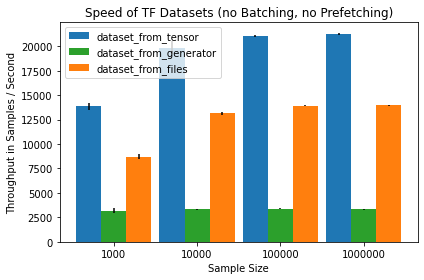

In [22]:
fig, ax = plt.subplots()

plot_speed_by_dataset_type(
    agg_results[(agg_results.batch_size == 1) & (agg_results.prefetch == 0.0)],
    f"Speed of TF Datasets (no Batching, no Prefetching)",
    ax=ax,
)

fig.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('TF_dataset_benchmark_slow.pdf')
plt.savefig('TF_dataset_benchmark_slow.png')
plt.savefig('TF_dataset_benchmark_slow.svg')

plt.show()

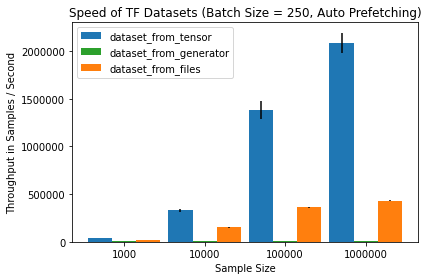

In [23]:
fig, ax = plt.subplots()

plot_speed_by_dataset_type(
    agg_results[(agg_results.batch_size == 250) & (agg_results.prefetch == -1.0)],
    f"Speed of TF Datasets (Batch Size = 250, Auto Prefetching)",
    ax=ax,
)

fig.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('TF_dataset_benchmark_fast.pdf')
plt.savefig('TF_dataset_benchmark_fast.png')
plt.savefig('TF_dataset_benchmark_fast.svg')

plt.show()

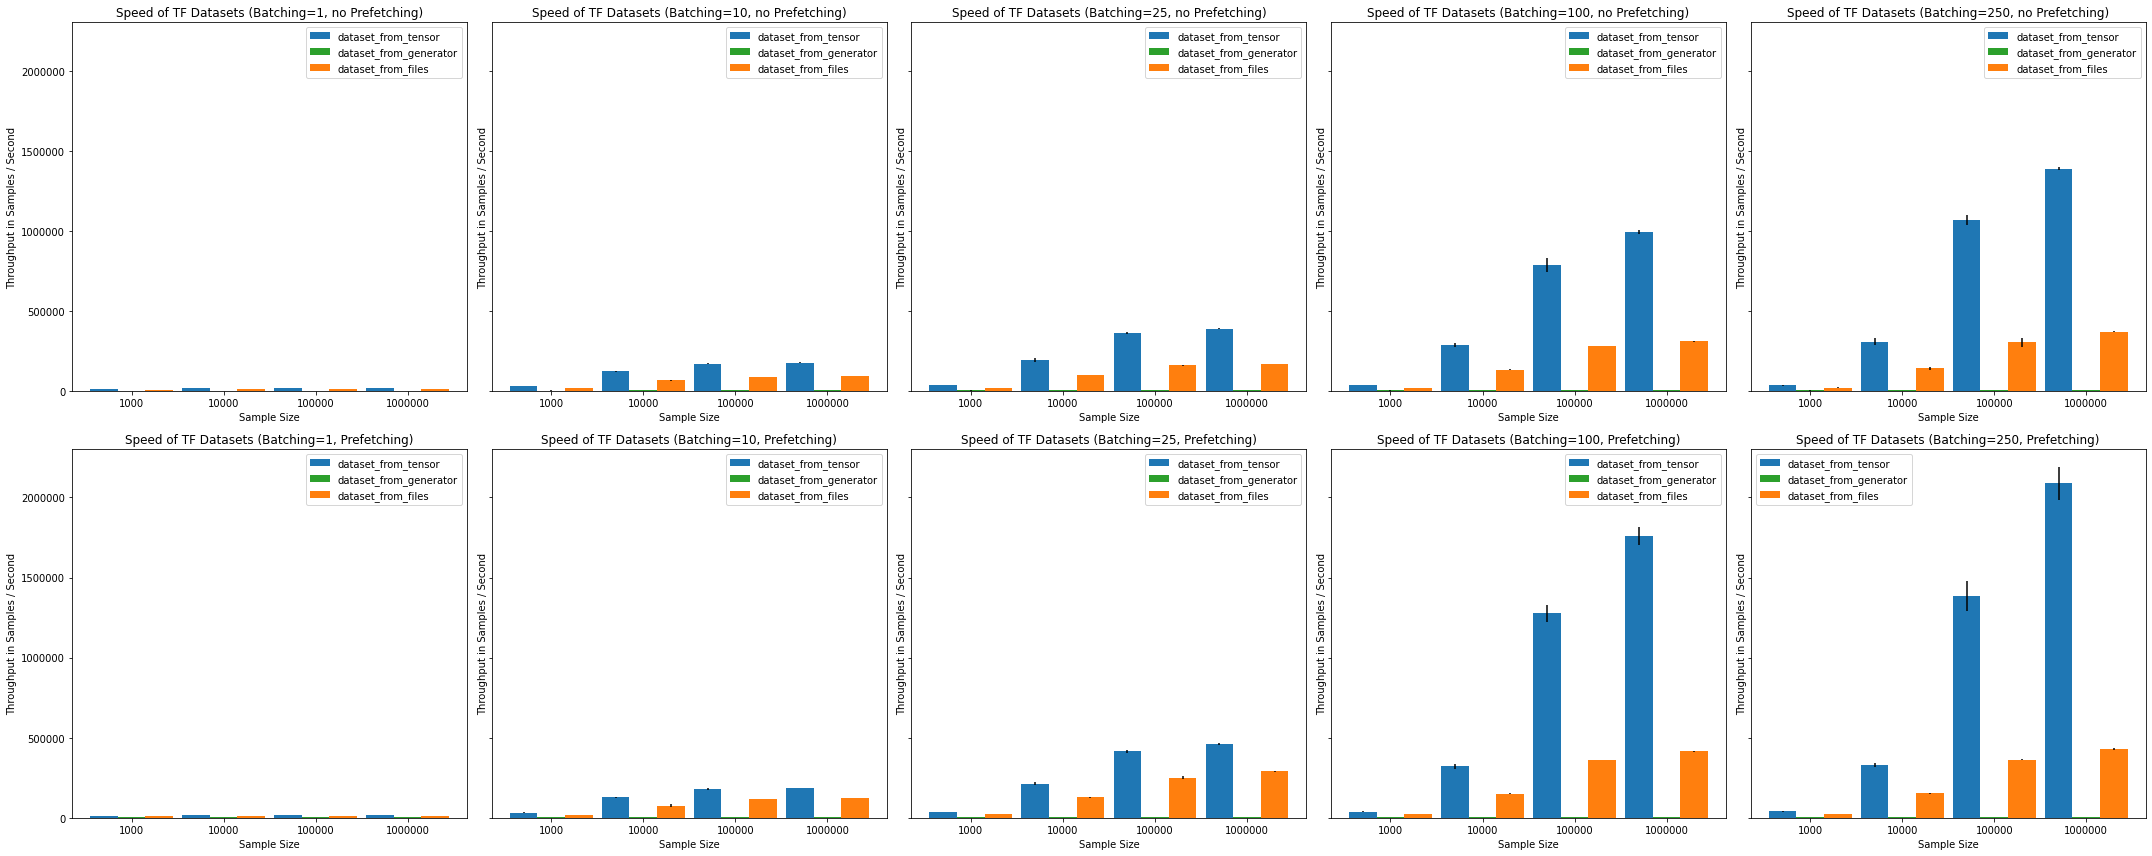

In [56]:
batch_sizes = agg_results.batch_size.unique()
prefetchings = agg_results.prefetch.unique()

size_per_subplot = 6

fig, axs = plt.subplots(
    len(prefetchings), 
    len(batch_sizes), 
    figsize=(len(batch_sizes) * size_per_subplot, len(prefetchings) * size_per_subplot), 
    sharey=True,
)

for j, prefetch in enumerate(reversed(prefetchings)):
    for i, batch_size in enumerate(batch_sizes):
        plot_speed_by_dataset_type(
            agg_results[(agg_results.batch_size == batch_size) & (agg_results.prefetch == prefetch)],
            f"Speed of TF Datasets (Batching={int(batch_size)}, {'no ' if prefetch == 0.0 else ''}Prefetching)",
            ax = axs[j][i],
        )

fig.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('TF_dataset_benchmark_horizontal.pdf')
plt.savefig('TF_dataset_benchmark_horizontal.png')
plt.savefig('TF_dataset_benchmark_horizontal.svg')

plt.show()

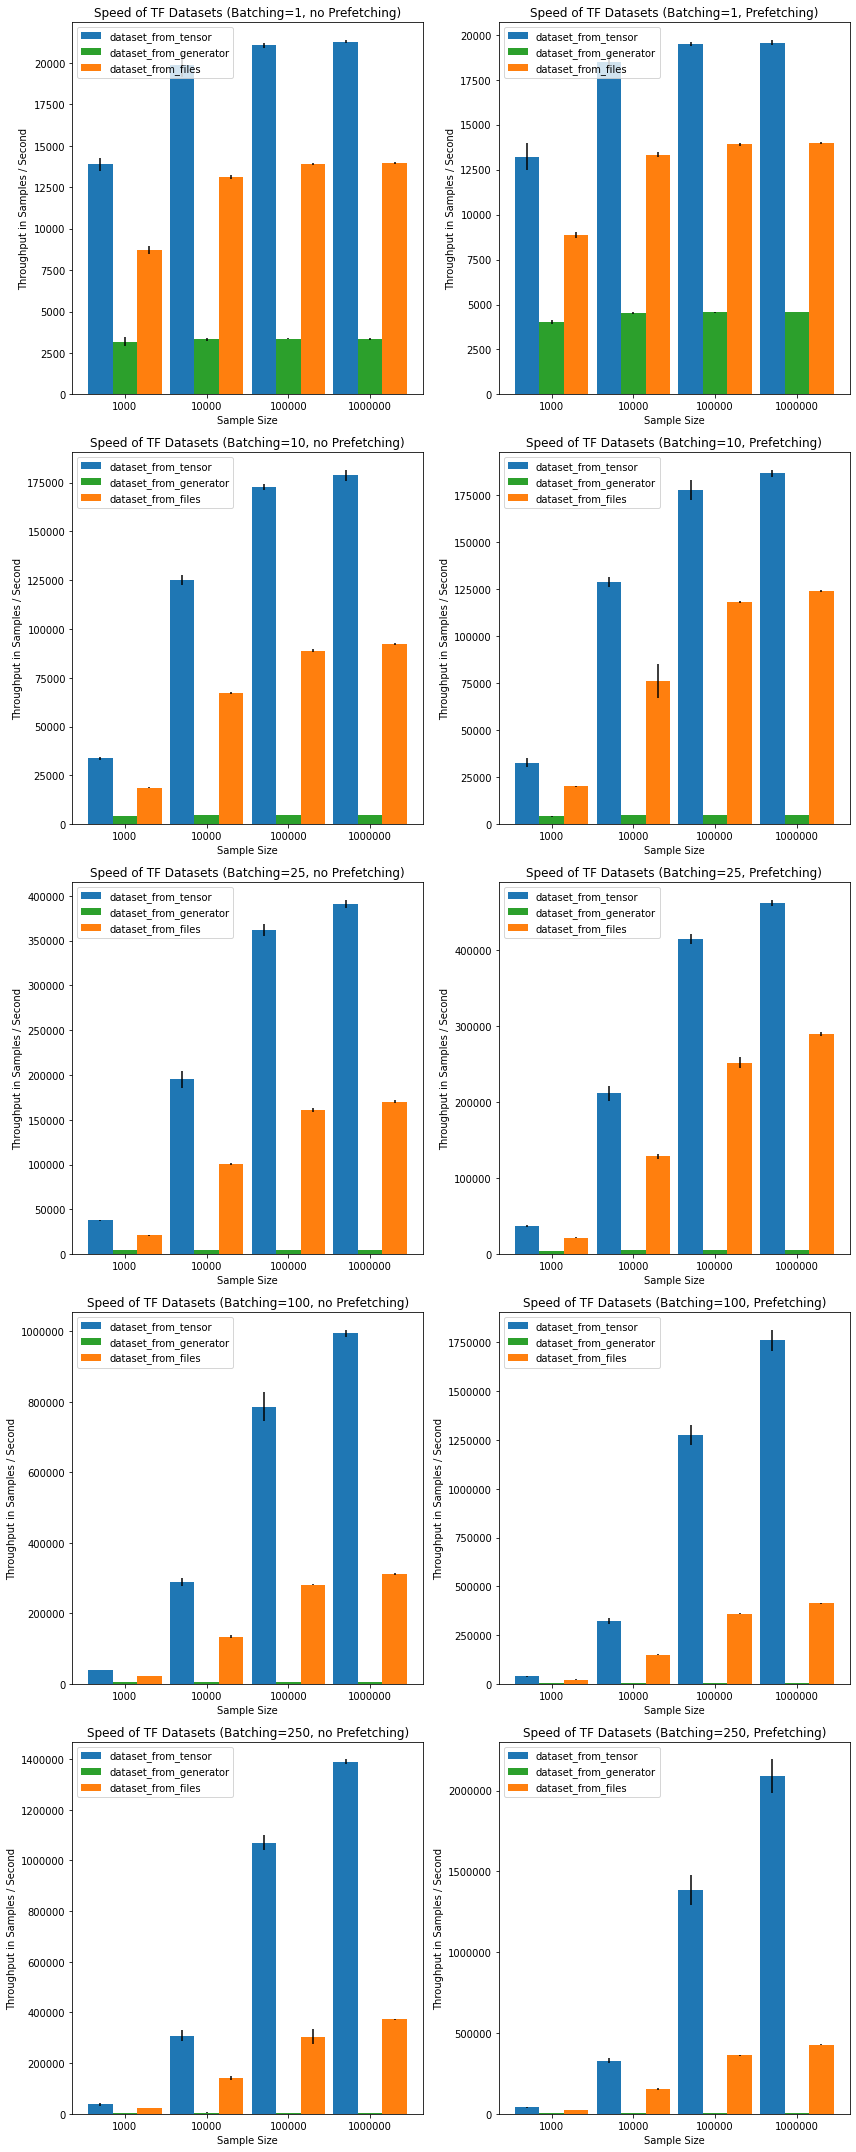

In [57]:
batch_sizes = agg_results.batch_size.unique()
prefetchings = agg_results.prefetch.unique()

size_per_subplot = 6

fig, axs = plt.subplots(
    len(batch_sizes), 
    len(prefetchings), 
    figsize=(len(prefetchings) * size_per_subplot, len(batch_sizes) * size_per_subplot), 
    sharey=False,
)

for j, prefetch in enumerate(reversed(prefetchings)):
    for i, batch_size in enumerate(batch_sizes):
        plot_speed_by_dataset_type(
            agg_results[(agg_results.batch_size == batch_size) & (agg_results.prefetch == prefetch)],
            f"Speed of TF Datasets (Batching={int(batch_size)}, {'no ' if prefetch == 0.0 else ''}Prefetching)",
            ax = axs[i][j],
        )

fig.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('TF_dataset_benchmark_vertical.pdf')
plt.savefig('TF_dataset_benchmark_vertical.png')
plt.savefig('TF_dataset_benchmark_vertical.svg')

plt.show()

## to Latex

In [35]:
def reduce_measurements(series):
    return series.describe()

latex_df = results\
.drop(columns=['run'])\
.groupby(['size', 'batch_size', 'prefetch'])\
.agg([np.mean, np.std])\
.reset_index()\
.apply(lambda x: round(x, 1))

latex_df['batch_size'] = latex_df.batch_size.astype(int)
latex_df['prefetch'] = latex_df.prefetch.astype(int)
latex_df

size batch_size prefetch dataset_from_tensor            \
                                               mean       std   
0      1000          1       -1             13221.0     758.5   
1      1000          1        0             13873.5     372.8   
2      1000         10       -1             32767.8    2248.6   
3      1000         10        0             33826.4     733.1   
4      1000         25       -1             36904.8    1548.6   
5      1000         25        0             37625.5     342.0   
6      1000        100       -1             39271.0    1751.7   
7      1000        100        0             39297.9     206.3   
8      1000        250       -1             39830.4    1124.5   
9      1000        250        0             36975.6    4585.5   
10    10000          1       -1             18489.9     429.4   
11    10000          1        0             19874.8     704.3   
12    10000         10       -1            128977.7    2764.5   
13    10000         10        0            125122.5    2610.3   
14    10000         25       -1            211372.8    9744.5   
15    10000         25        0            195112.4    9762.1   
16    10000        100       -1            321124.0   15452.7   
17    10000        100        0            288331.2   11405.2   
18    10000        250       -1            328863.4   14326.8   
19    10000        250        0            308735.9   22298.8   
20   100000          1       -1             19487.5     110.6   
21   100000          1        0             21055.5     124.0   
22   100000         10       -1            177924.6    5449.0   
23   100000         10        0            172842.3    1675.0   
24   100000         25       -1            414017.2    6590.6   
25   100000         25        0            362034.2    6480.9   
26   100000        100       -1           1275745.6   52701.6   
27   100000        100        0            786597.8   42070.2   
28   100000        250       -1           1384789.8   92084.9   
29   100000        250        0           1069640.7   29490.9   
30  1000000          1       -1             19553.8     149.1   
31  1000000          1        0             21277.6     100.4   
32  1000000         10       -1            186673.6    1853.1   
33  1000000         10        0            178677.5    2823.1   
34  1000000         25       -1            461496.8    4183.5   
35  1000000         25        0            391149.2    4353.8   
36  1000000        100       -1           1760382.2   55399.2   
37  1000000        100        0            994356.1   10432.7   
38  1000000        250       -1           2087734.0  104797.7   
39  1000000        250        0           1388767.7    9507.5   

   dataset_from_generator        dataset_from_files           
                     mean    std               mean      std  
0                  4006.7  117.4             8867.1    162.8  
1                  3184.9  280.4             8704.7    232.5  
2                  4292.8  200.8            20159.1    117.1  
3                  4237.9  142.2            18820.8    422.3  
4                  4295.5  326.0            21574.0    634.0  
5                  4435.1  296.2            20890.8    602.8  
6                  4547.1  176.9            21753.1   1152.8  
7                  4389.3  216.0            22324.3    172.2  
8                  4455.6  184.5            22382.4   1174.0  
9                  4536.4  218.7            22768.7    376.9  
10                 4521.0   58.1            13331.0    145.1  
11                 3315.4   80.3            13126.5    125.4  
12                 4852.3   45.9            76197.7   8959.6  
13                 4744.0   83.6            67308.1    681.6  
14                 4974.8  109.1           128385.1   2890.1  
15                 4899.2  130.2           100675.8   1382.3  
16                 4896.1   84.1           150390.9   3770.4  
17                 4974.5   83.8           134207.2   4234.2  
18              

In [36]:
latex_df.to_latex(
    buf='TF_dataset_benchmark_raw.tex', 
    index=False, 
    longtable=True,
    caption='Throughput of different Tensorflow datasets in samples per second (raw benchmark results)',
    label='tab:tfDatasetThroughputBenchmarkRaw'
)

Modify the latex table head to prevent duplicate labels and captions when the tables goes over multiple pages. Like this:

```
\caption{Runtime of multithreaded \mmproteo{} operations in seconds (raw benchmark results)}\label{tab:mmproteoMultithreadingBenchmarkRaw}\\
\toprule
 cores &    operation &  part &    run\_0 &    run\_1 &    run\_2 &    run\_3 &    run\_4 &      mean &         std &      min &      50\% &      max \\
\midrule
\endfirsthead
\caption[]{Runtime of multithreaded \mmproteo{} operations in seconds (raw benchmark results)}
\toprule
 cores &    operation &  part &    run\_0 &    run\_1 &    run\_2 &    run\_3 &    run\_4 &      mean &         std &      min &      50\% &      max \\
\midrule
\endhead
```